<a href="https://colab.research.google.com/github/andreagiral/CPE-595-Final-Project/blob/main/Pill_Generator_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CPE 595-WN: Applied Machine Learning**
**Team 4**

**Group Members:** Andrea Giraldo-Puerta, Juliana McGaffic and David Arguello

# **Data Cleaning of Database 1 ePillID: A Benchmark for Fine-Grained Pill Image Classification**

**Authored By:** Andrea Giraldo-Puerta

 Dataset Website: https://paperswithcode.com/dataset/epilliBenchmark  

 Repository: https://github.com/usuyama/ePillID-benchmark

In [ ]:
!git clone https://github.com/andreagiral/CPE-595-Final-Project.git

Cloning into 'CPE-595-Final-Project'...
remote: Enumerating objects: 14671, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14671 (delta 8), reused 14 (delta 4), pack-reused 14653 (from 2)
Receiving objects: 100% (14671/14671), 86.99 MiB | 13.66 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (33011/33011), done.


In [ ]:
import pandas as pd
import os
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Load data
df = pd.read_csv('/content/CPE-595-Final-Project/ePillID_data/all_labels.csv')
df.columns = df.columns.str.strip()  # Remove any leading/trailing whitespace
print("Initial Data Info:")
print(df.info())
print("--------------------------------------------------\n")
print("\nInitial Data Head:")
print(df.head())
print("--------------------------------------------------\n")
print("\nSummary Statistics:")
print(df.describe())
print("--------------------------------------------------\n")


Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13532 entries, 0 to 13531
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   images         13532 non-null  object
 1   pilltype_id    13532 non-null  object
 2   label_code_id  13532 non-null  int64 
 3   prod_code_id   13532 non-null  int64 
 4   is_ref         13532 non-null  bool  
 5   is_front       13532 non-null  bool  
 6   is_new         13532 non-null  bool  
 7   image_path     13532 non-null  object
 8   label          13532 non-null  object
dtypes: bool(3), int64(2), object(4)
memory usage: 674.1+ KB
None
--------------------------------------------------


Initial Data Head:
     images             pilltype_id  label_code_id  prod_code_id  is_ref  \
0     0.jpg  51285-0092-87_BE305F72          51285            92   False   
1    10.jpg  00093-0148-01_4629A34D             93           148   False   
2   100.jpg  00093-7248-06_7829BC3

In [ ]:
# Fix column whitespace and non-jpgs
df = df[df['image_path'].astype(str).str.endswith('.jpg')]
df['image_path'] = df['image_path'].astype(str).str.strip()
df['label'] = df['label'].astype(str).str.strip()

# Remove rows with missing data
df = df.dropna(subset=['image_path', 'label']).reset_index(drop=True)

# Set correct base folder
image_dir = '/content/CPE-595-Final-Project/ePillID_data/classification_data'

# Construct path
df['full_path'] = df['image_path'].apply(lambda x: os.path.join(image_dir, x))

# Test a few before filtering
print("Sample full paths:")
print(df['full_path'].head())

# Check if the file exists
df['exists'] = df['full_path'].apply(os.path.exists)

# Confirm how many actually exist
print(f"Images that exist: {df['exists'].sum()} / {len(df)}")
print("--------------------------------------------------\n")
# Filter final clean dataset
df = df[df['exists']].drop(columns='exists').reset_index(drop=True)

print(f"Final usable images: {len(df)}")
df[['image_path', 'full_path']].head()


Sample full paths:
0    /content/CPE-595-Final-Project/ePillID_data/cl...
1    /content/CPE-595-Final-Project/ePillID_data/cl...
2    /content/CPE-595-Final-Project/ePillID_data/cl...
3    /content/CPE-595-Final-Project/ePillID_data/cl...
4    /content/CPE-595-Final-Project/ePillID_data/cl...
Name: full_path, dtype: object
Images that exist: 13532 / 13532
--------------------------------------------------

Final usable images: 13532


,image_path,full_path
0,fcn_mix_weight/dc_224/0.jpg,/content/CPE-595-Final-Project/ePillID_data/cl...
1,fcn_mix_weight/dc_224/10.jpg,/content/CPE-595-Final-Project/ePillID_data/cl...
2,fcn_mix_weight/dc_224/100.jpg,/content/CPE-595-Final-Project/ePillID_data/cl...
3,fcn_mix_weight/dc_224/1003.jpg,/content/CPE-595-Final-Project/ePillID_data/cl...
4,fcn_mix_weight/dc_224/1004.jpg,/content/CPE-595-Final-Project/ePillID_data/cl...


In [ ]:
#Encoding Labels (for CNN output)
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Save encoder for decoding predictions later
with open('/content/CPE-595-Final-Project/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print(df[['label', 'label_encoded']].drop_duplicates().head())

                    label  label_encoded
0  51285-0092-87_BE305F72           2089
1  00093-0148-01_4629A34D             88
2  00093-7248-06_7829BC3D            356
3  00093-0928-06_6926B4E5            145
4  50111-0459-01_1C300E70           2032


In [ ]:
# Group by label and keep only classes with ≥1 images
grouped = df.groupby('label_encoded')
df_filtered = grouped.filter(lambda x: len(x) >=1 ).reset_index(drop=True)

print(f"Classes with ≥ 1 images: {df_filtered['label_encoded'].nunique()}")
print(f"Total images retained: {len(df_filtered)}")
print("--------------------------------------------------\n")
#Training / Validation Slip
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Classes with ≥ 1 images: 4902
Total images retained: 13532
--------------------------------------------------

Train set size: 10825
Validation set size: 2707


In [ ]:
#Cleaing all_labels

# Clean string/integer-based metadata columns
meta_cols = ['pilltype_id', 'label_code_id', 'prod_code_id']
df[meta_cols] = df[meta_cols].astype(str).apply(lambda col: col.str.strip())

# Convert codes to numeric types if needed later
df['label_code_id'] = pd.to_numeric(df['label_code_id'], errors='coerce')
df['prod_code_id'] = pd.to_numeric(df['prod_code_id'], errors='coerce')

# Clean and convert boolean flags
bool_cols = ['is_ref', 'is_front', 'is_new']

# Convert from string → boolean → integer (for ML input)
df[bool_cols] = df[bool_cols].apply(lambda col: col.astype(str).str.strip())
for col in bool_cols:
    df[col] = df[col].map(lambda x: 1 if str(x).lower() == 'true' else 0)


# Drop any rows with missing values in the important metadata columns
df_metadata_clean = df.dropna(subset=['pilltype_id', 'label_code_id', 'prod_code_id'])

print("Metadata cleaned successfully.")
print("--------------------------------------------------\n")
print(df_metadata_clean[meta_cols + bool_cols].sample(5))
print("--------------------------------------------------\n")



Metadata cleaned successfully.
--------------------------------------------------

                                            pilltype_id  label_code_id  \
5695                             68180-0518-01_070883B4          68180   
1385                             49884-0403-91_3E1C9F54          49884   
5373                             50111-0852-01_7B303DB1          50111   
8615  8fc50260e49940a427f2074efa112cf806d7a1f1258a35...          43063   
6240  d097edbad38650ce7266d2ab011fe3402f725f94d5b355...            173   

      prod_code_id  is_ref  is_front  is_new  
5695           518       1         1       0  
1385           403       0         1       0  
5373           852       1         1       0  
8615           710       1         0       1  
6240           824       1         1       1  
--------------------------------------------------



In [ ]:
#Prev. x2
print(f" Total rows before duplicate removal: {len(df)}")
dup_rows = df[df.duplicated()]
print(f"Duplicate rows found: {len(dup_rows)}")

# Preview a few duplicate rows (if any)
if not dup_rows.empty:
    print("\nSample duplicates:")
    print(dup_rows.head())

#Dropping duplicates
df = df.drop_duplicates().reset_index(drop=True)
print(f"Total rows after duplicate removal: {len(df)}")
print("--------------------------------------------------\n")
#Prev. n/a
print("\n Missing values per column BEFORE dropping:")
print(df.isnull().sum())

# Preview rows with missing metadata fields
missing_meta = df[df[['label_code_id', 'prod_code_id', 'pilltype_id']].isnull().any(axis=1)]
if not missing_meta.empty:
    print("\n Sample rows with missing metadata:")
    print(missing_meta.head())

# Drop rows with missing metadata
df_metadata_clean = df.dropna(subset=['pilltype_id', 'label_code_id', 'prod_code_id']).reset_index(drop=True)

print("\n Missing values per column AFTER dropping:")
print(df_metadata_clean.isnull().sum())
print("--------------------------------------------------\n")
print(f" Final metadata-cleaned dataset size: {len(df_metadata_clean)}")


 Total rows before duplicate removal: 13532
Duplicate rows found: 0
Total rows after duplicate removal: 13532
--------------------------------------------------


 Missing values per column BEFORE dropping:
images           0
pilltype_id      0
label_code_id    0
prod_code_id     0
is_ref           0
is_front         0
is_new           0
image_path       0
label            0
full_path        0
label_encoded    0
dtype: int64

 Missing values per column AFTER dropping:
images           0
pilltype_id      0
label_code_id    0
prod_code_id     0
is_ref           0
is_front         0
is_new           0
image_path       0
label            0
full_path        0
label_encoded    0
dtype: int64
--------------------------------------------------

 Final metadata-cleaned dataset size: 13532


In [ ]:
#from google.colab import files
# Save full cleaned dataset
#df.to_csv('/content/CPE-595-Final-Project/ePillID_data/cleaned_epillid_all_data.csv', index=False)
print("Saved: cleaned_epillid_all_data.csv")
print("--------------------------------------------------\n")
# Save metadata-clean subset
#df_metadata_clean.to_csv('/content/CPE-595-Final-Project/ePillID_data/cleaned_epillid_metadata_only.csv', index=False)
print("Saved: cleaned_epillid_metadata_only.csv")

#files.download('/content/CPE-595-Final-Project/ePillID_data/cleaned_epillid_all_data.csv')
#files.download('/content/CPE-595-Final-Project/ePillID_data/cleaned_epillid_metadata_only.csv')

Saved: cleaned_epillid_all_data.csv
--------------------------------------------------

Saved: cleaned_epillid_metadata_only.csv


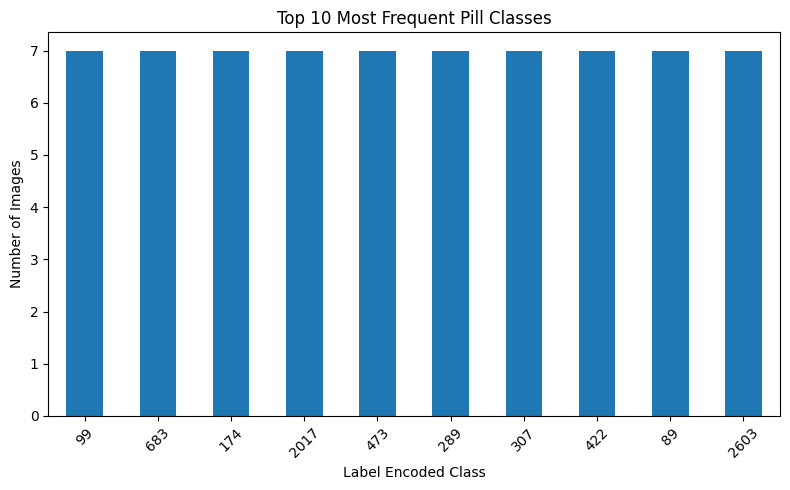

In [ ]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

# Class distribution plot
class_counts = df['label_encoded'].value_counts().head(10)

plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar')
plt.title("Top 10 Most Frequent Pill Classes")
plt.xlabel("Label Encoded Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

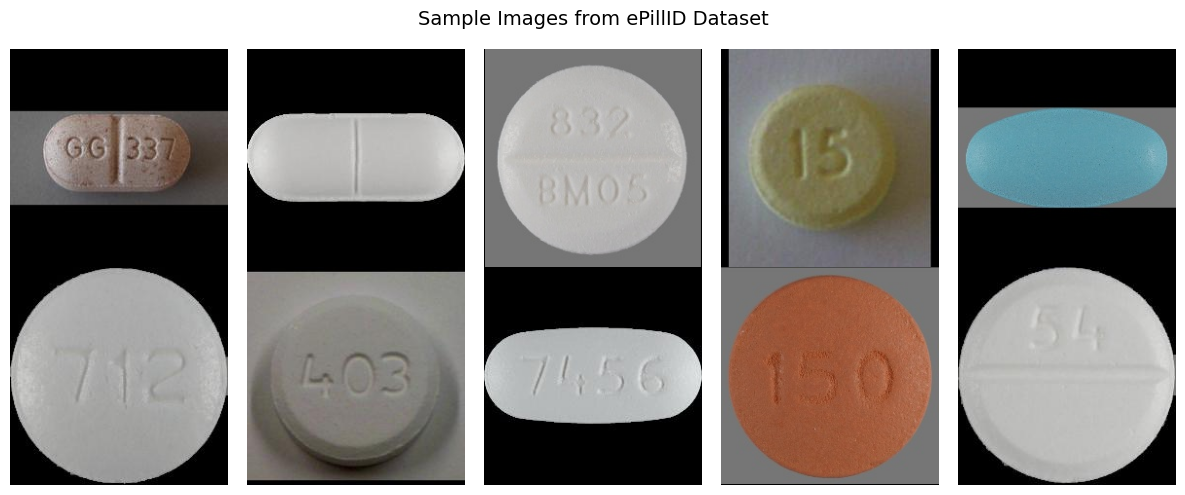

In [ ]:
#Sample images grid
# Randomly select 10 sample images from the dataset
sample_paths = df['full_path'].sample(10, random_state=42).tolist()

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for ax, img_path in zip(axes.flatten(), sample_paths):
    if os.path.exists(img_path):
        img = Image.open(img_path)
        ax.imshow(img)
    else:
        ax.imshow([[0.8, 0.8], [0.8, 0.8]], cmap='gray')  # placeholder if missing
    ax.axis('off')

fig.suptitle("Sample Images from ePillID Dataset", fontsize=14)
plt.tight_layout()
plt.show()


#**Machine Learning Algorithms Being Applied**  

         (User pill image)
                 ↓
        ┌───────────────────┐
        │  CNN: Image Model │─────────┐
        └───────────────────┘         │
        ┌───────────────────┐         │
        │   SVM: Metadata   │──(fallback if image low quality)
        └───────────────────┘         │
                 ↓                    ↓
        Predicted Pill Class or Name
                 ↓
      ┌────────────────────────────┐
      │ Decision Tree (FDALabel)  │
      └────────────────────────────┘
                 ↓
      → Outputs condition, usage, symptoms


## **Convolutional Neural Network (CNN)**
Authored By: David Arguello

Co-Authors: Andrea Giraldo-Puerta, Juliana McGaffic

In [ ]:
#Validation of image size
from PIL import Image
from collections import Counter

image_sizes = Counter()

# check what columns actually exist
df_clean = pd.read_csv('/content/CPE-595-Final-Project/cleaned_epillid_all_data.csv')
print("--------------------------------------------------\n")
print("\nInitial Data Info:\n")
print(df_clean.columns)
print(df_clean.head())

# Base folder where Images are stored
image_dir = '/content/CPE-595-Final-Project/ePillID_data/classification_data'

# Reconstruct full_path
df_clean['full_path'] = df_clean['image_path'].apply(lambda x: os.path.join(image_dir, x))

# Check
print("\n--------------------------------------------------\n")
print("Checking reconstruction:\n")
print(df_clean[['image_path', 'full_path']].head())

for path in df_clean['full_path']:
    try:
        with Image.open(path) as img:
            image_sizes[img.size] += 1  # (width, height)
    except Exception as e:
        print(f"Error loading {path}: {e}")

# Display summary of image sizes
print("--------------------------------------------------\n")
print("\nUnique image sizes and counts of data set:")
for size, count in image_sizes.items():
    print(f"Size {size}: {count} images")

--------------------------------------------------


Initial Data Info:

Index(['images', 'pilltype_id', 'label_code_id', 'prod_code_id', 'is_ref',
       'is_front', 'is_new', 'image_path', 'label'],
      dtype='object')
     images             pilltype_id  label_code_id  prod_code_id  is_ref  \
0     0.jpg  51285-0092-87_BE305F72          51285            92   False   
1    10.jpg  00093-0148-01_4629A34D             93           148   False   
2   100.jpg  00093-7248-06_7829BC3D             93          7248   False   
3  1003.jpg  00093-0928-06_6926B4E5             93           928   False   
4  1004.jpg  50111-0459-01_1C300E70          50111           459   False   

   is_front  is_new                      image_path                   label  
0     False   False     fcn_mix_weight/dc_224/0.jpg  51285-0092-87_BE305F72  
1     False   False    fcn_mix_weight/dc_224/10.jpg  00093-0148-01_4629A34D  
2      True   False   fcn_mix_weight/dc_224/100.jpg  00093-7248-06_7829BC3D  
3     Fa

In [ ]:
# Count how many samples each class has (Andrea)
le = LabelEncoder()
df_clean['label_encoded'] = le.fit_transform(df_clean['label'])

label_counts = df_clean['label_encoded'].value_counts()

print("Classes with at least:")
print(f"≥ 20 samples: {(label_counts >= 20).sum()}")
print(f"≥ 10 samples: {(label_counts >= 10).sum()}")
print(f"≥ 5 samples:  {(label_counts >= 5).sum()}")
print(f"≥ 2 samples:  {(label_counts >= 2).sum()}")

Classes with at least:
≥ 20 samples: 0
≥ 10 samples: 0
≥ 5 samples:  789
≥ 2 samples:  4902


In [ ]:
from sklearn.preprocessing import LabelEncoder
#Filter to pill classes with at least 5 images (for CNN training)(Andrea)

label_counts = df_clean['label_encoded'].value_counts()

valid_classes = label_counts[label_counts >= 5].index
df_filtered = df_clean[df_clean['label_encoded'].isin(valid_classes)].reset_index(drop=True)

# Re-encode labels to consecutive 0..(num_classes-1)
le = LabelEncoder()
df_filtered['label_encoded'] = le.fit_transform(df_filtered['label_encoded'])

num_classes = df_filtered['label_encoded'].nunique()
print(f"Final Number of usable classes: {num_classes}")

#Resplit train/val from filtered data
train_df, val_df = train_test_split(
    df_filtered,
    test_size=0.2,
    stratify=df_filtered['label_encoded'],
    random_state=42
)

#Train/Validation Split Print
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Final Number of usable classes: 789
Train set size: 4014
Validation set size: 1004


In [ ]:
!pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 696.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
#CNN code for pretrained Model set up

import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn

from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

#Define models BEFORE modifying output layer

# 1. ResNet18
resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# 2. DenseNet121
densenet_model = densenet121(weights=DenseNet121_Weights.DEFAULT)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, num_classes)

# 3. EfficientNet-B0
efficientnet_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 116MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 75.0MB/s]


In [ ]:
# Cleaned Dataset converted to RGB

class PillDataset(Dataset):
  # Constructor
  def __init__(self, dataframe, transform=None):
    self.df_clean = dataframe.reset_index(drop=True)
    self.transform = transform

  def __len__(self):
    return len(self.df_clean)

  def __getitem__(self, idx):
    img_path = self.df_clean.loc[idx, 'full_path']
    label = self.df_clean.loc[idx, 'label_encoded']
    try:
      img = Image.open(img_path).convert('RGB')
      if self.transform:
        img = self.transform(img)
      return img, label
    except Exception as e:
      print(f"Error loading {img_path}: {e}")

In [ ]:
#Setting up tranforms and Dataloaders

# For pretrained ResNet, use ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet18 expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Must match training size
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_dataset = PillDataset(train_df, transform=train_transform)
val_dataset = PillDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# Use of ResNet18 CNN model for initial training

# 1. ResNet18
resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)  # pretrained
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# 2. DenseNet121
densenet_model = densenet121(weights=DenseNet121_Weights.DEFAULT)  # pretrained
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, num_classes)

# 3. EfficientNet-B0
efficientnet_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)  # pretrained
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, num_classes)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to device
resnet_model.to(device)
densenet_model.to(device)
efficientnet_model.to(device)

# Define criterion and optimizers (one per model)
criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
densenet_optimizer = optim.Adam(densenet_model.parameters(), lr=0.001)
efficientnet_optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

In [ ]:
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a DataFrame to store metrics for each model
metrics_df = pd.DataFrame(columns=[
    'Model', 'Epoch',
    'Train_Accuracy','Train_F1','Train_Recall','Train_Precision',
    'Val_Accuracy','Val_F1','Val_Recall','Val_Precision'
])

def train_model(model, train_loader, val_loader, criterion, optimizer, device, model_name, epochs=5):
    global metrics_df
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_preds = []
        train_labels = []

        # --- Training loop ---
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Compute training metrics
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted', zero_division=0)
        train_recall = recall_score(train_labels, train_preds, average='weighted', zero_division=0)
        train_precision = precision_score(train_labels, train_preds, average='weighted', zero_division=0)

        # --- Validation loop ---
        model.eval()
        val_loss = 0
        val_correct = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * imgs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

                val_preds.extend(outputs.argmax(1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Compute validation metrics
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
        val_recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
        val_precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)

        # Append metrics to DataFrame
        metrics_df.loc[len(metrics_df)] = [
            model_name, epoch+1,
            train_acc, train_f1, train_recall, train_precision,
            val_acc, val_f1, val_recall, val_precision
        ]

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss/len(train_loader.dataset):.4f}, Acc: {train_acc:.4f}, "
              f"F1: {train_f1:.4f}, Recall: {train_recall:.4f}, Precision: {train_precision:.4f} | "
              f"Val Loss: {val_loss/len(val_loader.dataset):.4f}, Acc: {val_acc:.4f}, "
              f"F1: {val_f1:.4f}, Recall: {val_recall:.4f}, Precision: {val_precision:.4f}"
        )

# Train ResNet18
print('\nResNet18 Results:\n')
train_model(resnet_model, train_loader, val_loader, criterion, resnet_optimizer, device, model_name='ResNet18', epochs=25)
print("--------------------------------------------------\n")
# Train DenseNet121
print('\nDenseNet121 Results:\n')
train_model(densenet_model, train_loader, val_loader, criterion, densenet_optimizer, device, model_name='DenseNet121', epochs=25)
print("--------------------------------------------------\n")
# Train EfficientNet-B0
print('\nEfficientNet-B0 Results:\n')
train_model(efficientnet_model, train_loader, val_loader, criterion, efficientnet_optimizer, device, model_name='EfficientNet-B0', epochs=25)
print("--------------------------------------------------\n")


ResNet18 Results:

Epoch 1/25 | Train Loss: 7.0317, Acc: 0.0025, F1: 0.0012, Recall: 0.0025, Precision: 0.0009 | Val Loss: 6.2753, Acc: 0.0090, F1: 0.0017, Recall: 0.0090, Precision: 0.0010
Epoch 2/25 | Train Loss: 5.7483, Acc: 0.0117, F1: 0.0071, Recall: 0.0117, Precision: 0.0059 | Val Loss: 5.3132, Acc: 0.0289, F1: 0.0085, Recall: 0.0289, Precision: 0.0062
Epoch 3/25 | Train Loss: 4.8941, Acc: 0.0326, F1: 0.0228, Recall: 0.0326, Precision: 0.0224 | Val Loss: 4.5572, Acc: 0.0588, F1: 0.0234, Recall: 0.0588, Precision: 0.0175
Epoch 4/25 | Train Loss: 4.3557, Acc: 0.0688, F1: 0.0556, Recall: 0.0688, Precision: 0.0578 | Val Loss: 4.4525, Acc: 0.0727, F1: 0.0398, Recall: 0.0727, Precision: 0.0345
Epoch 5/25 | Train Loss: 3.9186, Acc: 0.1104, F1: 0.0941, Recall: 0.1104, Precision: 0.0978 | Val Loss: 4.0272, Acc: 0.0996, F1: 0.0587, Recall: 0.0996, Precision: 0.0540
Epoch 6/25 | Train Loss: 3.5827, Acc: 0.1477, F1: 0.1306, Recall: 0.1477, Precision: 0.1335 | Val Loss: 4.4640, Acc: 0.1006, 

In [ ]:
# Save metrics to CSV
#from google.colab import files
#metrics_df.to_csv('model_metrics.csv', index=False)
print("Saved: model_metrics.csv")
print("--------------------------------------------------\n")
#files.download('/content/CPE-595-Final-Project/model_metrics.csv')

Saved: model_metrics.csv
--------------------------------------------------



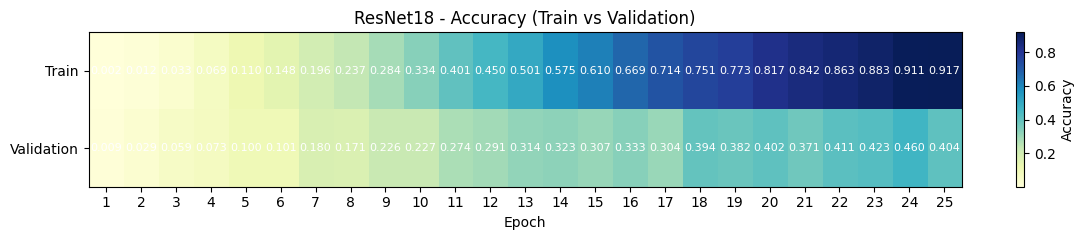

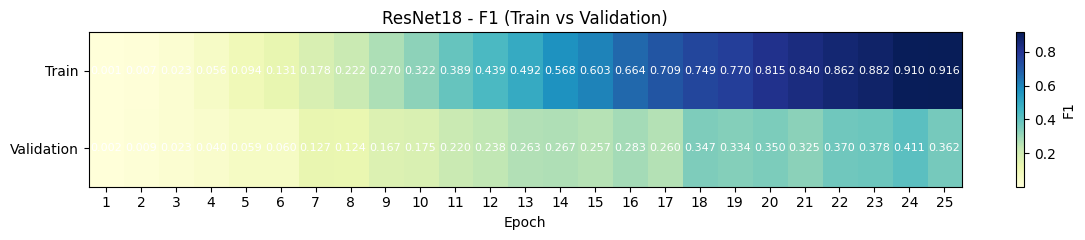

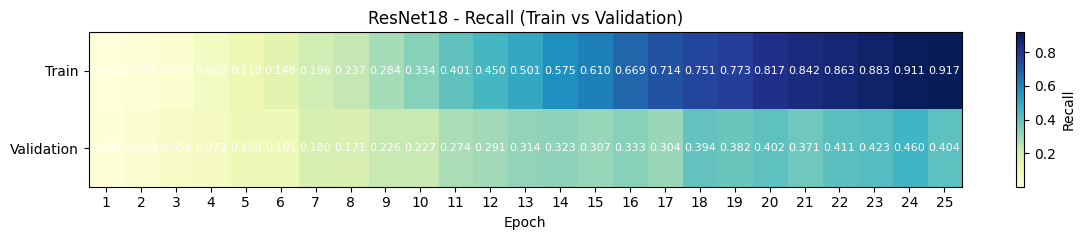

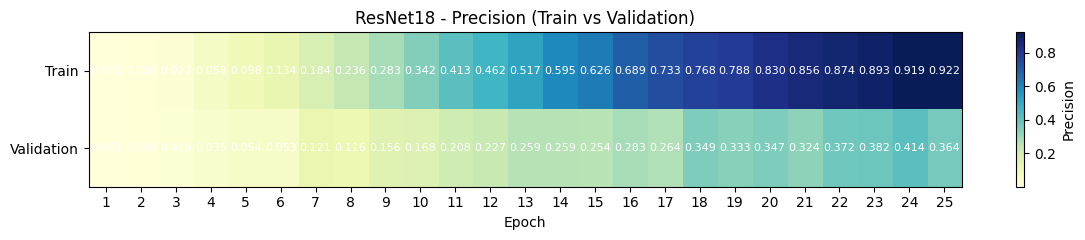

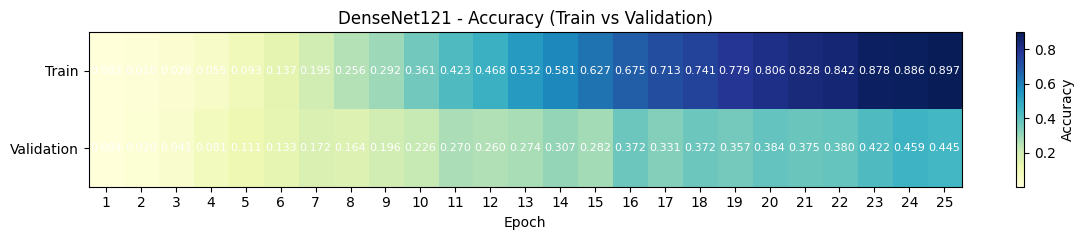

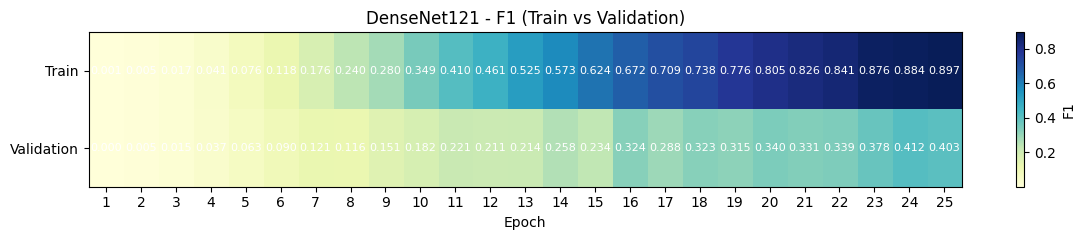

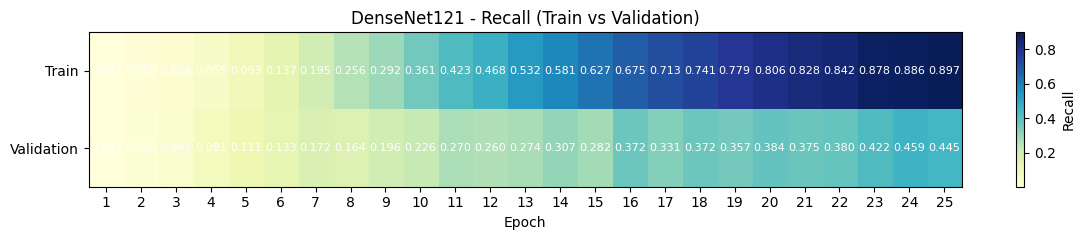

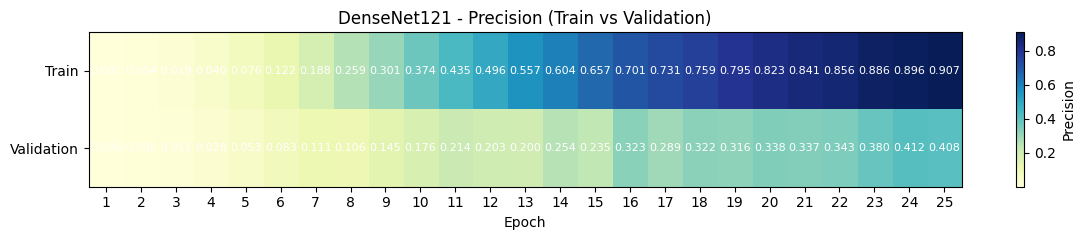

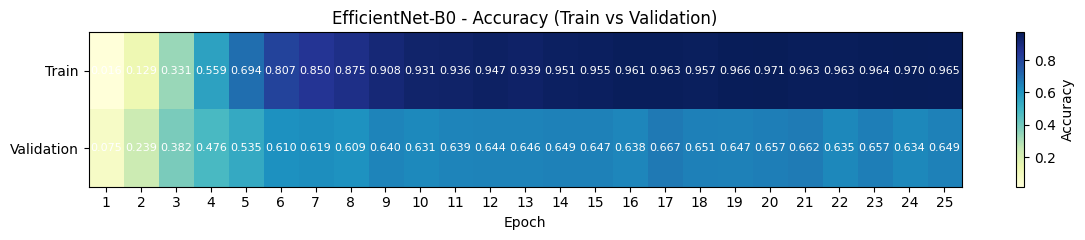

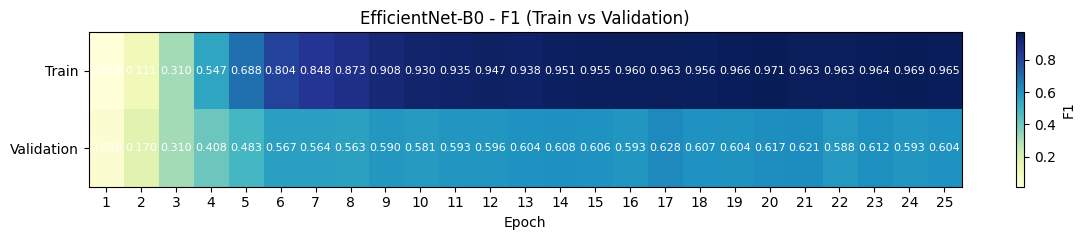

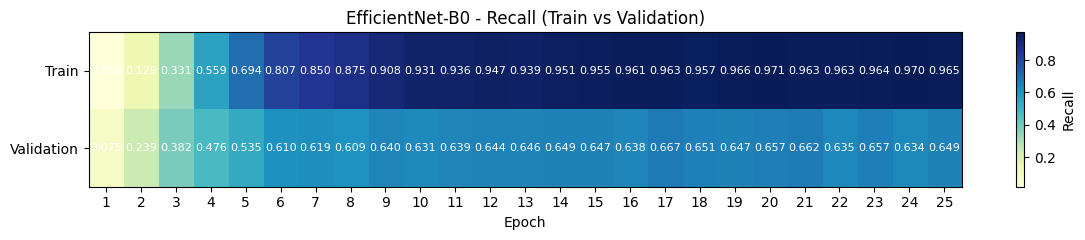

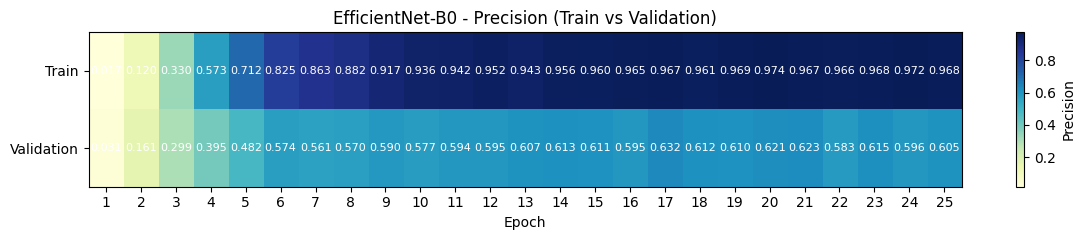

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define metrics and datasets
metrics_base = ['Accuracy', 'F1', 'Recall', 'Precision']
datasets = ['Train', 'Val']
epochs = metrics_df['Epoch'].unique()

def create_metric_matrix(metrics_df, model_name, metric_name, dataset):
    """Creates a matrix: rows = metric+dataset, columns = epochs"""
    col_name = f"{dataset}_{metric_name}"
    matrix = np.array(metrics_df[metrics_df['Model'] == model_name][col_name])
    return matrix.reshape(1, -1)

def plot_heatmap(matrix, model_name, metric_name, epochs):
    fig, ax = plt.subplots(figsize=(12, 2))
    im = ax.imshow(matrix, cmap='YlGnBu', aspect='auto')

    ax.set_xticks(np.arange(len(epochs)))
    ax.set_xticklabels(epochs)
    ax.set_yticks([0])
    ax.set_yticklabels([f"{metric_name}"])

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, f"{matrix[i, j]:.3f}", ha='center', va='center', color='white', fontsize=8)

    ax.set_xlabel("Epoch")
    ax.set_title(f"{model_name} - {metric_name} over Epochs")
    plt.colorbar(im, ax=ax, label=metric_name)
    plt.tight_layout()
    plt.show()


# Generate heatmaps for each model, metric, and dataset
for model in metrics_df['Model'].unique():
    for metric in metrics_base:
        # Stack training and validation metrics vertically
        train_matrix = create_metric_matrix(metrics_df, model, metric, 'Train')
        val_matrix = create_metric_matrix(metrics_df, model, metric, 'Val')
        combined_matrix = np.vstack([train_matrix, val_matrix])

        fig, ax = plt.subplots(figsize=(12, 2.5))
        im = ax.imshow(combined_matrix, cmap='YlGnBu', aspect='auto')

        ax.set_xticks(np.arange(len(epochs)))
        ax.set_xticklabels(epochs)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['Train', 'Validation'])

        # Annotate each cell
        for i in range(combined_matrix.shape[0]):
            for j in range(combined_matrix.shape[1]):
                ax.text(j, i, f"{combined_matrix[i, j]:.3f}", ha='center', va='center', color='white', fontsize=8)

        ax.set_xlabel("Epoch")
        ax.set_title(f"{model} - {metric} (Train vs Validation)")
        plt.colorbar(im, ax=ax, label=metric)
        plt.tight_layout()
        plt.show()

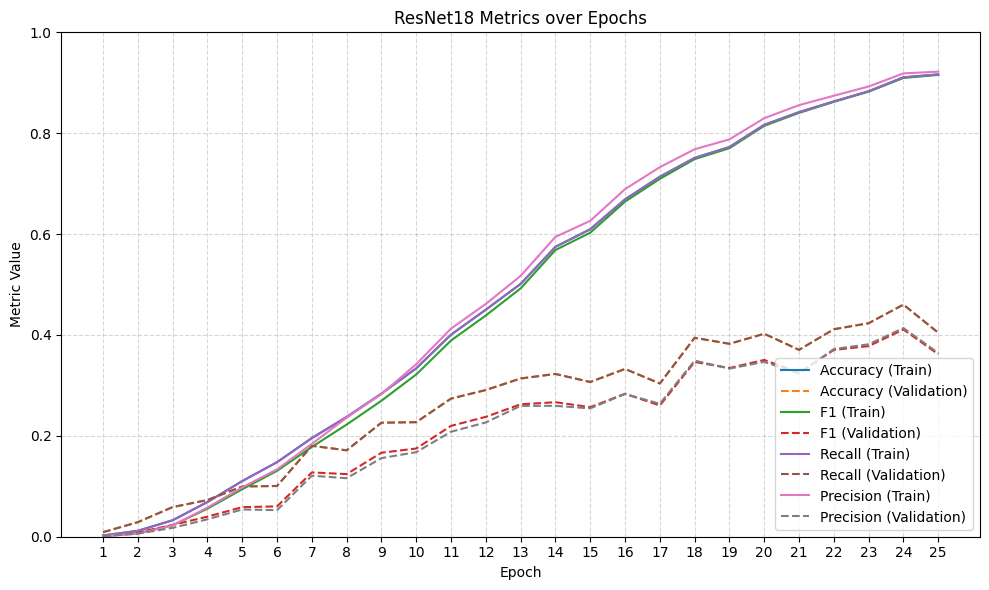

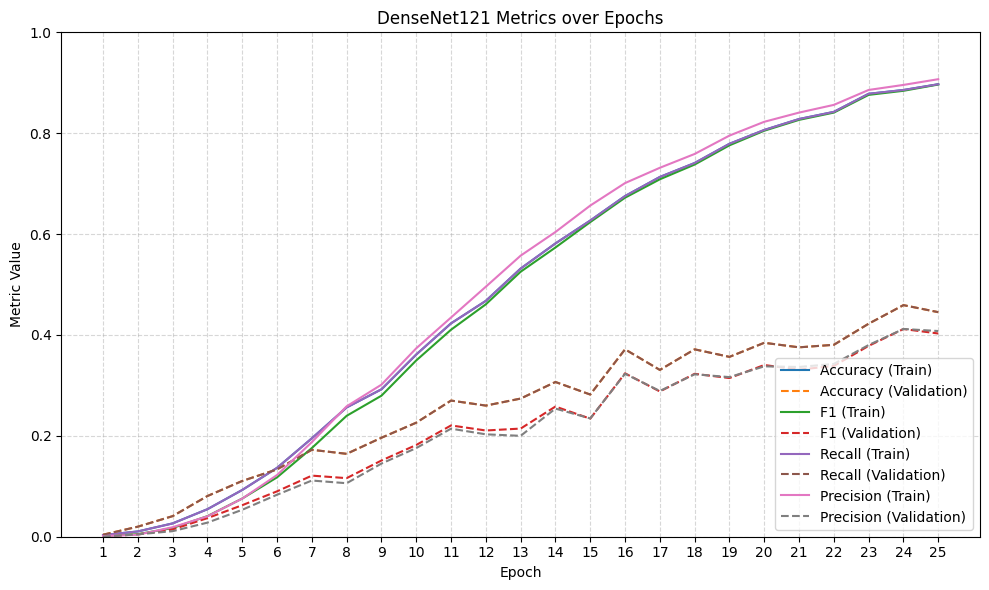

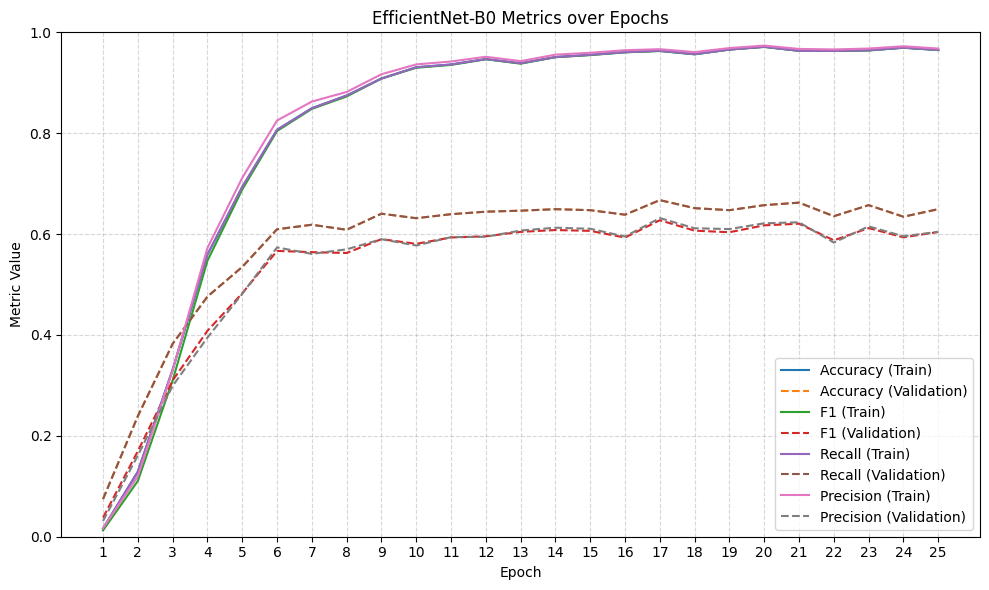

In [ ]:
metrics_base = ['Accuracy', 'F1', 'Recall', 'Precision']
datasets = ['Train', 'Val']
epochs = metrics_df['Epoch'].unique()

for model in metrics_df['Model'].unique():
    plt.figure(figsize=(10, 6))

    for metric in metrics_base:
        train_values = metrics_df[metrics_df['Model'] == model]['Train_' + metric].values
        val_values = metrics_df[metrics_df['Model'] == model]['Val_' + metric].values

        plt.plot(epochs, train_values, label=f"{metric} (Train)", linestyle='-')
        plt.plot(epochs, val_values, label=f"{metric} (Validation)", linestyle='--')

    plt.title(f"{model} Metrics over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.xticks(epochs)
    plt.ylim(0, 1)  # since all metrics are between 0 and 1
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

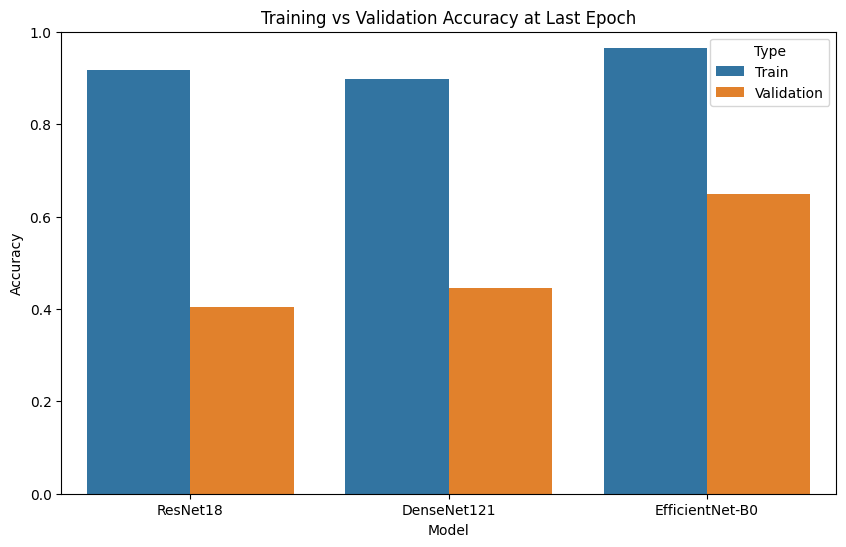


Max Training vs Validation Accuracy for each model:

ResNet18 -> Max Train Accuracy: 0.9165, Max Validation Accuracy: 0.4044
DenseNet121 -> Max Train Accuracy: 0.8971, Max Validation Accuracy: 0.4452
EfficientNet-B0 -> Max Train Accuracy: 0.9651, Max Validation Accuracy: 0.6494


In [ ]:
# Filter for final epoch
final_metrics = metrics_df[metrics_df['Epoch'] == metrics_df['Epoch'].max()]

# Melt the DataFrame to have Train/Val as a variable
plot_data = final_metrics.melt(id_vars='Model',
                               value_vars=['Train_Accuracy', 'Val_Accuracy'],
                               var_name='Type', value_name='Accuracy')

# Rename Type values for cleaner legend
plot_data['Type'] = plot_data['Type'].replace({'Train_Accuracy':'Train', 'Val_Accuracy':'Validation'})

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Accuracy', hue='Type', data=plot_data)
plt.title("Training vs Validation Accuracy at Last Epoch")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.show()

# Print max training vs validation Accuracy for each model
print("\nMax Training vs Validation Accuracy for each model:\n")
for model in final_metrics['Model']:
    train_acc = final_metrics.loc[final_metrics['Model']==model, 'Train_Accuracy'].values[0]
    val_acc = final_metrics.loc[final_metrics['Model']==model, 'Val_Accuracy'].values[0]
    print(f"{model} -> Max Train Accuracy: {train_acc:.4f}, Max Validation Accuracy: {val_acc:.4f}")

## **Support Vector Machine (SVM)**
Authored By: Juliana McGaffic

Co-Authors: Andrea Giraldo-Puerta, David Arguello

In [ ]:
import os
import numpy as np
from PIL import Image
from cuml.svm import SVC as cuSVC
import cupy as cp
from sklearn.metrics import classification_report

# Filter for classes with fewer than 5 images
label_counts = df_clean['label_encoded'].value_counts()
rare_classes = label_counts[label_counts < 5].index
df_svm = df_clean[df_clean['label_encoded'].isin(rare_classes)].reset_index(drop=True)

# Using all classes
df_all = df_clean.reset_index(drop=True)


In [ ]:
# Prepare images
from PIL import Image
import numpy as np
from tqdm import tqdm

def load_images_for_svm(df, target_size=(64, 64)):
    X = []
    y = []
    for _, row in df.iterrows():
        try:
            img = Image.open(row['full_path']).convert('L')
            img = img.resize(target_size)
            img_array = np.asarray(img, dtype=np.float32) / 255.0
            X.append(img_array.flatten())
            y.append(row['label_encoded'])
        except Exception as e:
            print(f"Error processing {row['full_path']}: {e}")

    X_np = np.array(X)
    y_np = np.array(y)
    return X_np, y_np

X_svm_np, y_svm_np = load_images_for_svm(df_svm)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Optional PCA
X = X_svm_np
y = y_svm_np

X = PCA(n_components=50).fit_transform(X)

# 2-Fold Cross-Validation
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in kf.split(X, y):
    model = LinearSVC(max_iter=10000)
    model.fit(X[train_idx], y[train_idx])
    preds = model.predict(X[val_idx])
    acc = accuracy_score(y[val_idx], preds)
    scores.append(acc)

print(f"Mean accuracy: {np.mean(scores):.4f}")

Mean accuracy: 0.1762


In [ ]:
from collections import Counter
from random import choice

most_common = Counter(y_svm_np).most_common(1)[0][1] / len(y_svm_np)
print(f"Majority class baseline accuracy: {most_common:.4f}")


Majority class baseline accuracy: 0.0005



Testing PCA with 10 components
Accuracy:  0.0305
F1 Score:  0.0109
Precision: 0.0079
Recall:    0.0289
Runtime:   56.30s

Testing PCA with 20 components
Accuracy:  0.0969
F1 Score:  0.0582
Precision: 0.0476
Recall:    0.0971
Runtime:   114.58s

Testing PCA with 50 components
Accuracy:  0.1770
F1 Score:  0.1424
Precision: 0.1291
Recall:    0.1784
Runtime:   517.76s

Testing PCA with 60 components
Accuracy:  0.1767
F1 Score:  0.1455
Precision: 0.1332
Recall:    0.1781
Runtime:   719.31s

Testing PCA with 70 components
Accuracy:  0.1755
F1 Score:  0.1460
Precision: 0.1343
Recall:    0.1769
Runtime:   945.00s


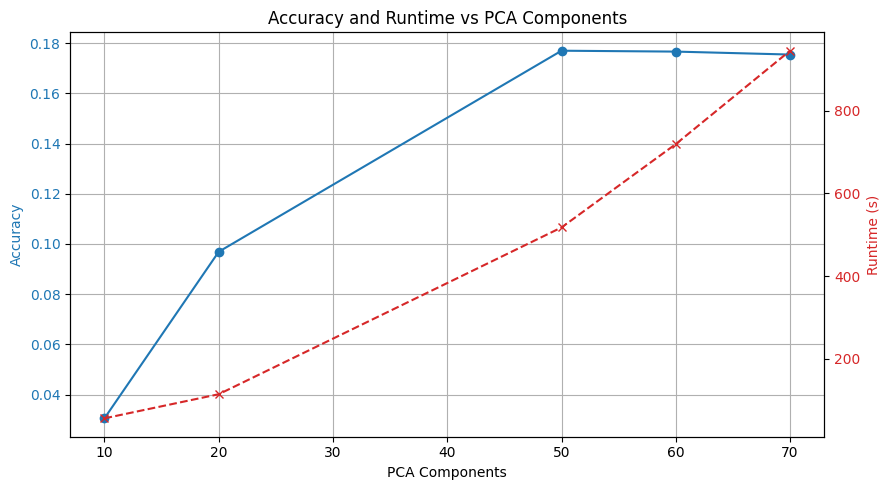


Summary of Metrics by PCA Dimension:
   PCA Components  Accuracy  F1 Score  Precision  Recall  Runtime (s)
0              10    0.0305    0.0109     0.0079  0.0289      56.3041
1              20    0.0969    0.0582     0.0476  0.0971     114.5837
2              50    0.1770    0.1424     0.1291  0.1784     517.7620
3              60    0.1767    0.1455     0.1332  0.1781     719.3134
4              70    0.1755    0.1460     0.1343  0.1769     945.0050


In [ ]:
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

pca_dims = [10, 20, 50, 60, 70]
accuracies = []
runtimes = []
f1_scores = []
precisions = []
recalls = []

for n in pca_dims:
    print(f"\nTesting PCA with {n} components")
    X_pca = PCA(n_components=n).fit_transform(X_svm_np)

    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    acc_list = []
    f1_list = []
    prec_list = []
    rec_list = []

    start_time = time.time()
    for train_idx, val_idx in kf.split(X_pca, y_svm_np):
        model = LinearSVC(max_iter=10000)
        model.fit(X_pca[train_idx], y_svm_np[train_idx])
        preds = model.predict(X_pca[val_idx])
        y_true = y_svm_np[val_idx]

        acc_list.append(accuracy_score(y_true, preds))
        f1_list.append(f1_score(y_true, preds, average='macro', zero_division=0))
        prec_list.append(precision_score(y_true, preds, average='macro', zero_division=0))
        rec_list.append(recall_score(y_true, preds, average='macro', zero_division=0))

    end_time = time.time()
    runtime = end_time - start_time

    # Collect mean metrics
    accuracies.append(np.mean(acc_list))
    f1_scores.append(np.mean(f1_list))
    precisions.append(np.mean(prec_list))
    recalls.append(np.mean(rec_list))
    runtimes.append(runtime)

    print(f"Accuracy:  {np.mean(acc_list):.4f}")
    print(f"F1 Score:  {np.mean(f1_list):.4f}")
    print(f"Precision: {np.mean(prec_list):.4f}")
    print(f"Recall:    {np.mean(rec_list):.4f}")
    print(f"Runtime:   {runtime:.2f}s")

# Plot
fig, ax1 = plt.subplots(figsize=(9, 5))

color = 'tab:blue'
ax1.set_xlabel('PCA Components')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(pca_dims, accuracies, marker='o', color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Runtime (s)', color=color)
ax2.plot(pca_dims, runtimes, marker='x', linestyle='--', color=color, label='Runtime')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Accuracy and Runtime vs PCA Components')
plt.tight_layout()
plt.show()

# Summary table
import pandas as pd

summary = pd.DataFrame({
    'PCA Components': pca_dims,
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls,
    'Runtime (s)': runtimes
})

print("\nSummary of Metrics by PCA Dimension:")
print(summary.round(4))


Testing LinearSVC with C = 0.1
C=0.1: Accuracy=0.0409, Runtime=761.92s

Testing LinearSVC with C = 1
C=1: Accuracy=0.1771, Runtime=520.08s

Testing LinearSVC with C = 2
C=2: Accuracy=0.1902, Runtime=1119.00s

Testing LinearSVC with C = 3
C=3: Accuracy=0.1942, Runtime=1778.92s


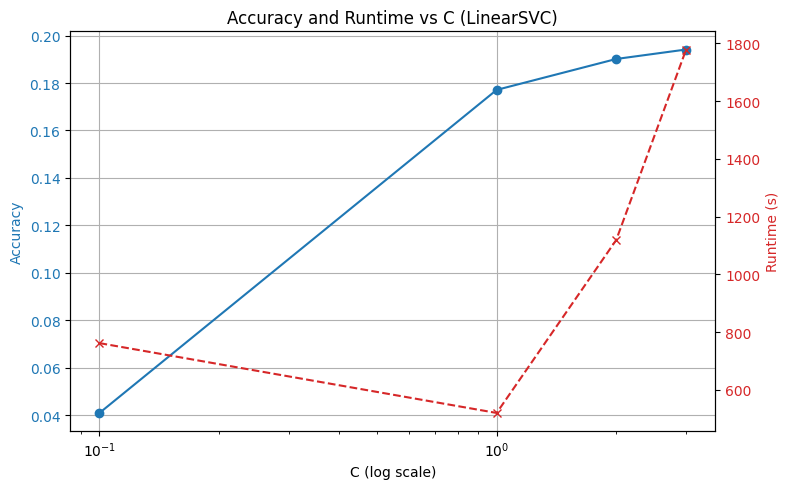

In [ ]:
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

C_values = [0.1, 1, 2, 3]
accuracies = []
runtimes = []

X = PCA(n_components=50).fit_transform(X_svm_np)

for C in C_values:
    print(f"\nTesting LinearSVC with C = {C}")
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    scores = []

    start_time = time.time()
    for train_idx, val_idx in kf.split(X, y_svm_np):
        model = LinearSVC(C=C, max_iter=10000)
        model.fit(X[train_idx], y_svm_np[train_idx])
        preds = model.predict(X[val_idx])
        acc = accuracy_score(y_svm_np[val_idx], preds)
        scores.append(acc)
    end_time = time.time()

    mean_acc = np.mean(scores)
    runtime = end_time - start_time

    accuracies.append(mean_acc)
    runtimes.append(runtime)

    print(f"C={C}: Accuracy={mean_acc:.4f}, Runtime={runtime:.2f}s")

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('C (log scale)')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(C_values, accuracies, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Runtime (s)', color=color)
ax2.plot(C_values, runtimes, marker='x', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Accuracy and Runtime vs C (LinearSVC)')
plt.tight_layout()
plt.show()




Starting joint tuning of PCA components and k-NN...


PCA Components: 50
Testing k = 1... Accuracy: 0.2980 | F1: 0.2736 | Time: 0.75s
Testing k = 3... Accuracy: 0.1490 | F1: 0.0952 | Time: 0.63s
Testing k = 5... Accuracy: 0.0956 | F1: 0.0464 | Time: 0.66s
Testing k = 7... Accuracy: 0.0702 | F1: 0.0283 | Time: 0.66s

PCA Components: 100
Testing k = 1... Accuracy: 0.2899 | F1: 0.2642 | Time: 0.76s
Testing k = 3... Accuracy: 0.1490 | F1: 0.0949 | Time: 0.73s
Testing k = 5... Accuracy: 0.0942 | F1: 0.0457 | Time: 1.04s
Testing k = 7... Accuracy: 0.0715 | F1: 0.0291 | Time: 1.08s

PCA Components: 150
Testing k = 1... Accuracy: 0.2833 | F1: 0.2562 | Time: 0.84s
Testing k = 3... Accuracy: 0.1474 | F1: 0.0936 | Time: 0.87s
Testing k = 5... Accuracy: 0.0951 | F1: 0.0467 | Time: 0.85s
Testing k = 7... Accuracy: 0.0726 | F1: 0.0293 | Time: 0.82s

PCA Components: 200
Testing k = 1... Accuracy: 0.2802 | F1: 0.2520 | Time: 0.92s
Testing k = 3... Accuracy: 0.1473 | F1: 0.0923 | Time: 0.89s
Testing k

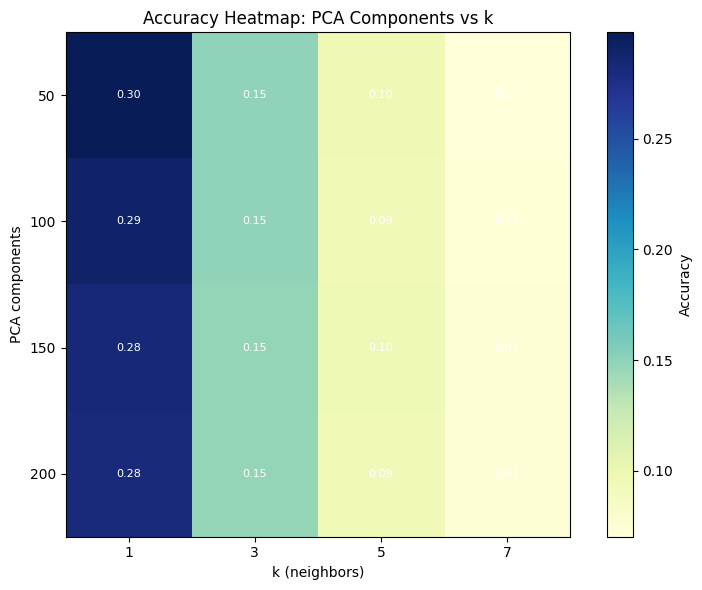

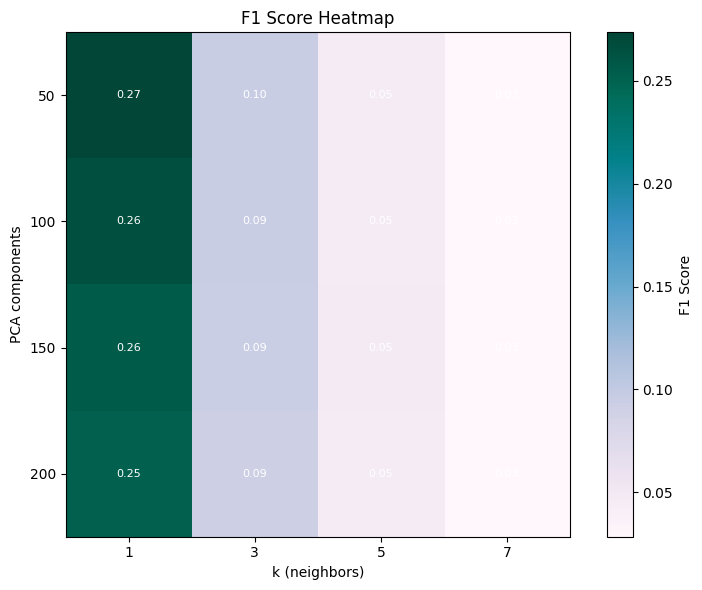

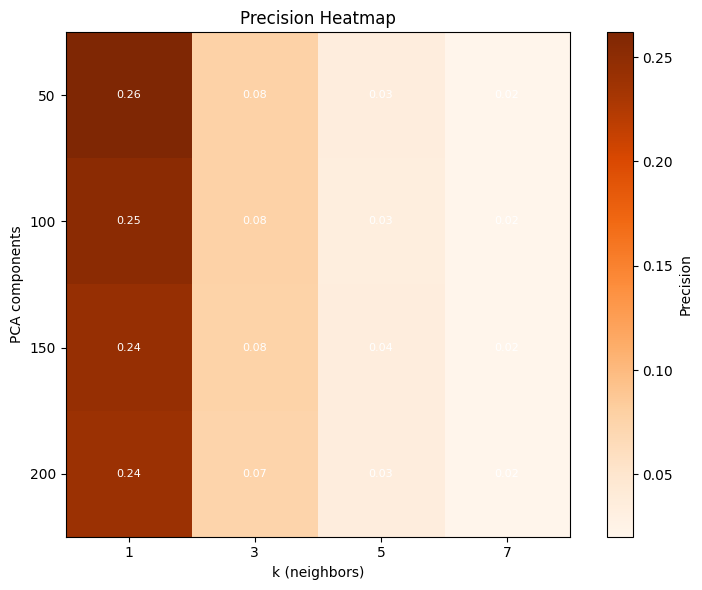

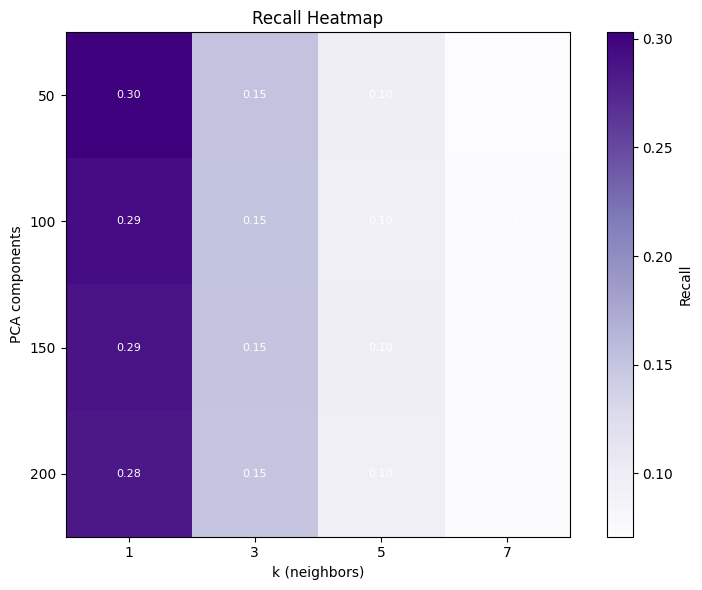

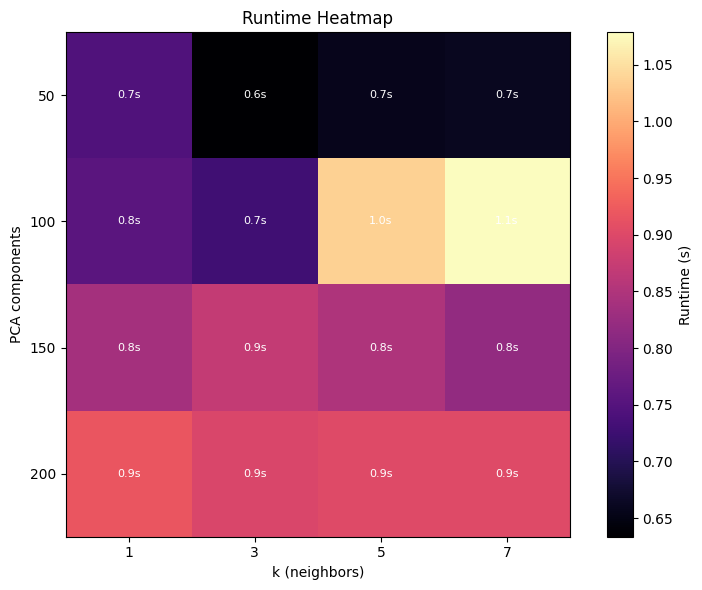

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Define parameter grid
pca_components = [50, 100, 150, 200]
k_values = [1, 3, 5, 7]

results = []

print("\nStarting joint tuning of PCA components and k-NN...\n")

# Grid search
for n_comp in pca_components:
    print(f"\nPCA Components: {n_comp}")
    pca = PCA(n_components=n_comp)
    X_reduced = pca.fit_transform(X_svm_np)

    for k in k_values:
        print(f"Testing k = {k}", end='... ')
        start = time.time()

        acc_scores, f1_scores, prec_scores, rec_scores = [], [], [], []
        skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
        for train_idx, val_idx in skf.split(X_reduced, y_svm_np):
            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(X_reduced[train_idx], y_svm_np[train_idx])
            preds = model.predict(X_reduced[val_idx])

            acc_scores.append(accuracy_score(y_svm_np[val_idx], preds))
            f1_scores.append(f1_score(y_svm_np[val_idx], preds, average='macro', zero_division=0))
            prec_scores.append(precision_score(y_svm_np[val_idx], preds, average='macro', zero_division=0))
            rec_scores.append(recall_score(y_svm_np[val_idx], preds, average='macro', zero_division=0))

        runtime = time.time() - start

        results.append({
            'pca': n_comp,
            'k': k,
            'acc': np.mean(acc_scores),
            'f1': np.mean(f1_scores),
            'prec': np.mean(prec_scores),
            'rec': np.mean(rec_scores),
            'time': runtime
        })

        print(f"Accuracy: {np.mean(acc_scores):.4f} | F1: {np.mean(f1_scores):.4f} | Time: {runtime:.2f}s")


def create_metric_matrix(results, metric_name):
    matrix = np.zeros((len(pca_components), len(k_values)))
    for res in results:
        i = pca_components.index(res['pca'])
        j = k_values.index(res['k'])
        matrix[i, j] = res[metric_name]
    return matrix

acc_matrix = create_metric_matrix(results, 'acc')
f1_matrix = create_metric_matrix(results, 'f1')
prec_matrix = create_metric_matrix(results, 'prec')
rec_matrix = create_metric_matrix(results, 'rec')
time_matrix = create_metric_matrix(results, 'time')

# Plotting function
def plot_heatmap(matrix, title, label, fmt=".2f", cmap='viridis', is_time=False):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(matrix, cmap=cmap)

    ax.set_xticks(np.arange(len(k_values)))
    ax.set_yticks(np.arange(len(pca_components)))
    ax.set_xticklabels(k_values)
    ax.set_yticklabels(pca_components)

    for i in range(len(pca_components)):
        for j in range(len(k_values)):
            value = f"{matrix[i, j]:.1f}s" if is_time else f"{matrix[i, j]:.2f}"
            ax.text(j, i, value, ha='center', va='center', color='white', fontsize=8)

    ax.set_xlabel("k (neighbors)")
    ax.set_ylabel("PCA components")
    ax.set_title(title)
    plt.colorbar(im, label=label)
    plt.tight_layout()
    plt.show()

# Generate all heatmaps
plot_heatmap(acc_matrix, "Accuracy Heatmap: PCA Components vs k", "Accuracy", cmap='YlGnBu')
plot_heatmap(f1_matrix, "F1 Score Heatmap", "F1 Score", cmap='PuBuGn')
plot_heatmap(prec_matrix, "Precision Heatmap", "Precision", cmap='Oranges')
plot_heatmap(rec_matrix, "Recall Heatmap", "Recall", cmap='Purples')
plot_heatmap(time_matrix, "Runtime Heatmap", "Runtime (s)", fmt=".1f", cmap='magma', is_time=True)

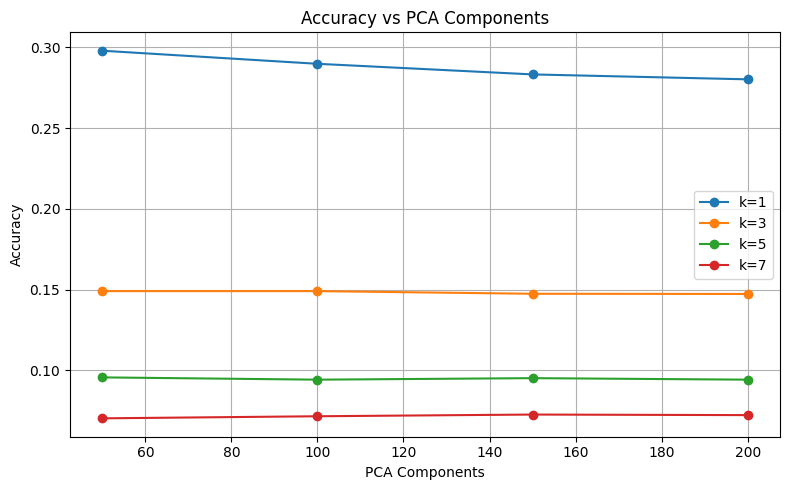

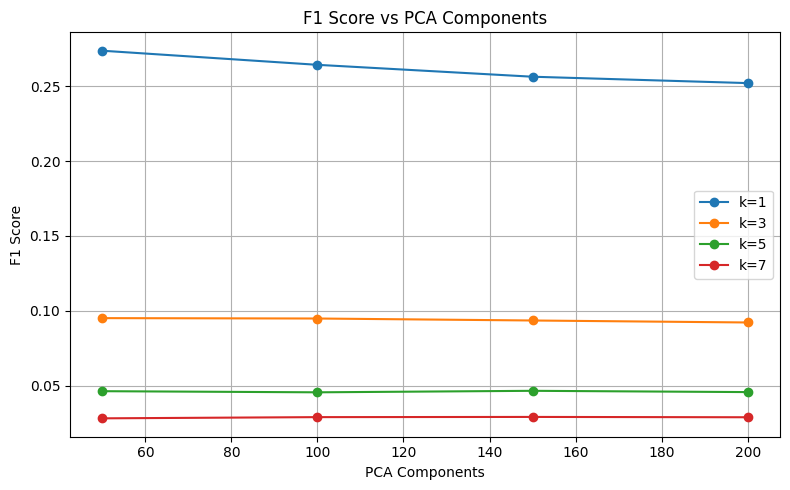

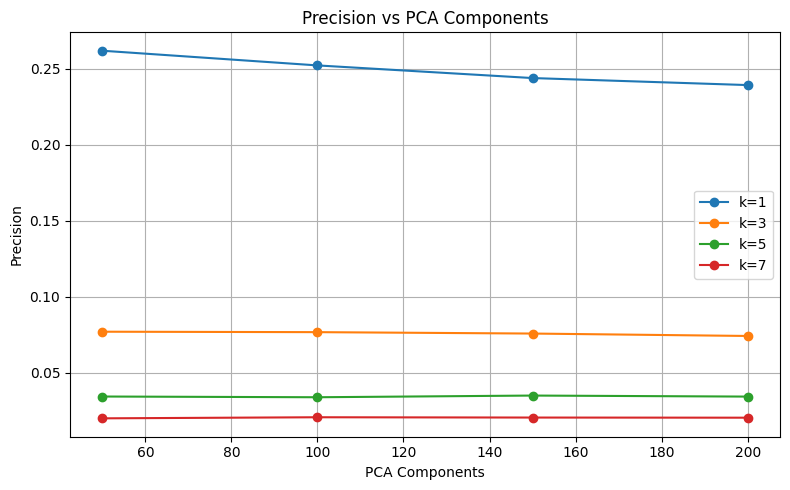

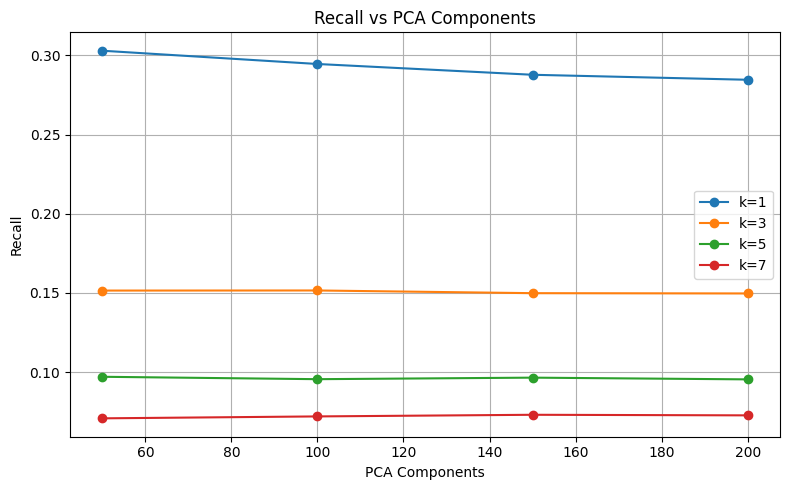

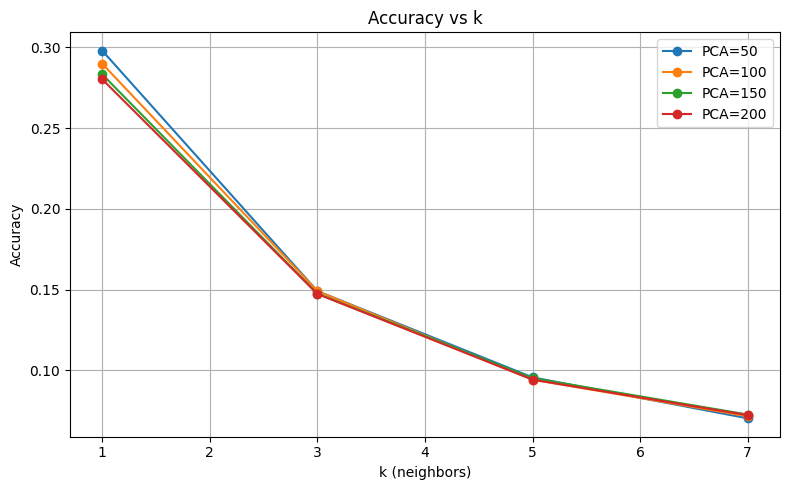

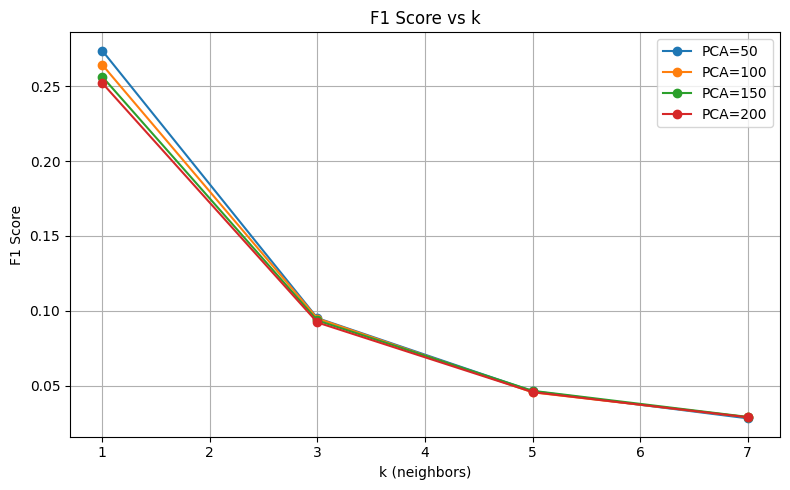

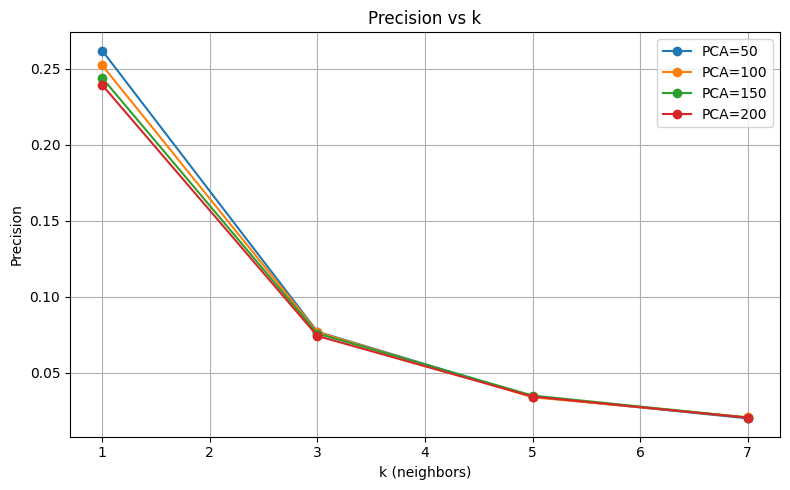

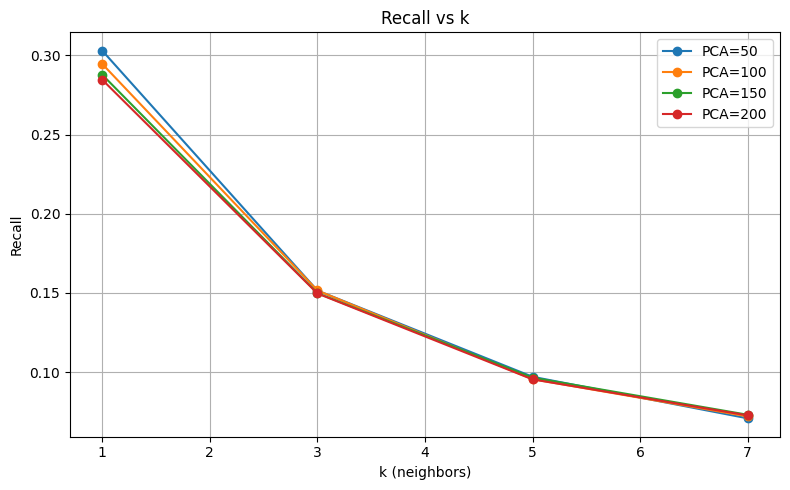


🔝 Top 10 configurations by F1:

 pca  k      acc       f1     prec      rec     time
  50  1 0.297980 0.273599 0.261851 0.303003 0.745589
 100  1 0.289875 0.264186 0.252190 0.294615 0.756466
 150  1 0.283298 0.256247 0.243876 0.287807 0.837502
 200  1 0.280244 0.251992 0.239262 0.284646 0.917230
  50  3 0.149049 0.095183 0.077137 0.151471 0.633551
 100  3 0.149049 0.094930 0.076847 0.151532 0.728624
 150  3 0.147404 0.093607 0.075923 0.149830 0.871327
 200  3 0.147287 0.092283 0.074338 0.149647 0.894824
 150  5 0.095137 0.046690 0.035164 0.096462 0.847695
  50  5 0.095607 0.046441 0.034534 0.097009 0.657434


In [ ]:
import pandas as pd

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Line plot: Metric vs PCA components (one line per k)
metrics = ['acc', 'f1', 'prec', 'rec']
metric_names = {
    'acc': 'Accuracy',
    'f1': 'F1 Score',
    'prec': 'Precision',
    'rec': 'Recall'
}

for metric in metrics:
    plt.figure(figsize=(8, 5))
    for k in k_values:
        subset = df_results[df_results['k'] == k]
        plt.plot(subset['pca'], subset[metric], marker='o', label=f'k={k}')
    plt.title(f'{metric_names[metric]} vs PCA Components')
    plt.xlabel('PCA Components')
    plt.ylabel(metric_names[metric])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Line plot: Metric vs k (one line per PCA component)
for metric in metrics:
    plt.figure(figsize=(8, 5))
    for pca_dim in pca_components:
        subset = df_results[df_results['pca'] == pca_dim]
        plt.plot(subset['k'], subset[metric], marker='o', label=f'PCA={pca_dim}')
    plt.title(f'{metric_names[metric]} vs k')
    plt.xlabel('k (neighbors)')
    plt.ylabel(metric_names[metric])
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

top_metric = 'f1'
top_n = 10

summary = df_results.sort_values(by=top_metric, ascending=False).head(top_n)
summary_display = summary[['pca', 'k', 'acc', 'f1', 'prec', 'rec', 'time']]

print(f"\n🔝 Top {top_n} configurations by {top_metric.upper()}:\n")
print(summary_display.to_string(index=False))

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Load pretrained ResNet50 model
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Extract features from images
def extract_feature(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        feature = resnet(img_tensor).squeeze()
    return feature.numpy()

X_features = np.array([extract_feature(p) for p in df_svm['full_path']])
y_labels = df_svm['label_encoded'].to_numpy()

# Normalize features for cosine similarity
X_normalized = normalize(X_features, norm='l2')

# Evaluate k-NN (k=1) with cosine distance
knn_cosine = KNeighborsClassifier(n_neighbors=1, metric='cosine')
scores = cross_val_score(knn_cosine, X_normalized, y_labels, cv=2)
print(f"Cosine k-NN (k=1) Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Evaluate k-NN (k=3) with distance-weighted cosine voting
knn_weighted = KNeighborsClassifier(n_neighbors=3, metric='cosine', weights='distance')
scores_w = cross_val_score(knn_weighted, X_normalized, y_labels, cv=2)
print(f"Weighted Cosine k-NN (k=3) Accuracy: {scores_w.mean():.4f} ± {scores_w.std():.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s]


Cosine k-NN (k=1) Accuracy: 0.1561 ± 0.0121
Weighted Cosine k-NN (k=3) Accuracy: 0.1563 ± 0.0123


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
logreg_scores = cross_val_score(logreg, X, y, cv=3)

print(f"Logistic Regression CV Accuracy: {logreg_scores.mean():.4f} ± {logreg_scores.std():.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Logistic Regression CV Accuracy: 0.0680 ± 0.0043


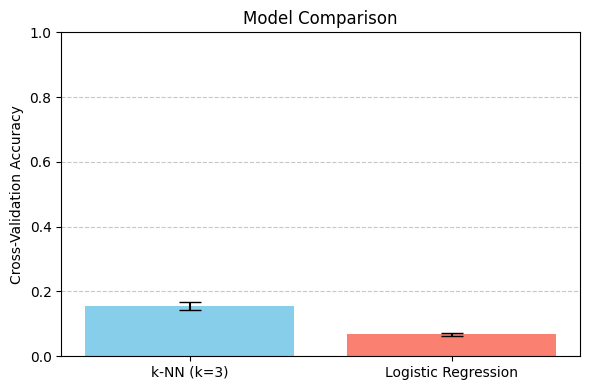

In [ ]:
import matplotlib.pyplot as plt
knn_scores = scores_w  # use the weighted cosine k-NN (k=3) results

models = ['k-NN (k=3)', 'Logistic Regression']
means = [knn_scores.mean(), logreg_scores.mean()]
stds = [knn_scores.std(), logreg_scores.std()]

plt.figure(figsize=(6, 4))
plt.bar(models, means, yerr=stds, capsize=8, color=['skyblue', 'salmon'])
plt.ylabel("Cross-Validation Accuracy")
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# PCA
X = PCA(n_components=50).fit_transform(X_svm_np)
y = y_svm_np

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

top_confident_samples = []
N = 10  # top-N per fold (or change to overall later)

print("Running cross-validation with confidence extraction...\n")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = LinearSVC(C=1.0, max_iter=10000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    decision_scores = model.decision_function(X_val)

    if decision_scores.ndim > 1:
        confidences = np.max(decision_scores, axis=1)
    else:
        confidences = np.abs(decision_scores)

    # Get top-N confident predictions for this fold
    top_idx = np.argsort(confidences)[-N:][::-1]

    for i in top_idx:
        sample = {
            'fold': fold,
            'confidence': confidences[i],
            'true_label': y_val[i],
            'predicted_label': y_pred[i],
            'features': X_val[i]
        }
        top_confident_samples.append(sample)

    acc = accuracy_score(y_val, y_pred)
    print(f"Fold {fold}: Accuracy = {acc:.4f}, Top-{N} samples collected")

print("\nDone collecting confident predictions across folds.")



Running cross-validation with confidence extraction...

Fold 1: Accuracy = 0.1708, Top-10 samples collected
Fold 2: Accuracy = 0.1811, Top-10 samples collected

Done collecting confident predictions across folds.


# **Data Cleaning Database 2  FDALabel: Full-Text Search of Drug Product Labeling**

**Authored By: Andrea Giraldo-Puerta**

Dataset Website: https://www.fda.gov/science-research/bioinformatics-tools/fdalabel-full-text-search-drug-product-labeling   


In [ ]:
!pip -q install requests requests_cache tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 7.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd, requests, time, math, random
import os
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re
import requests_cache
from tqdm import tqdm
from typing import List, Tuple

#Load data
df = pd.read_csv('/content/CPE-595-Final-Project/fdalabel-query.csv')
df.columns = df.columns.str.strip()  # Remove any leading/trailing whitespace
print("Initial Data Info:")
print(df.info())
print("--------------------------------------------------\n")
print("\nInitial Data Head:")
print(df.head())
print("--------------------------------------------------\n")
print("\nSummary Statistics:")
print(df.describe())
print("--------------------------------------------------\n")

/tmp/ipython-input-2543769290.py:12: DtypeWarning: Columns (21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/CPE-595-Final-Project/fdalabel-query.csv')


Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126045 entries, 0 to 126044
Data columns (total 24 columns):
 #   Column                                                      Non-Null Count   Dtype  
---  ------                                                      --------------   -----  
 0   Labeling Type                                               126045 non-null  object 
 1   Dosage Form(s)                                              126039 non-null  object 
 2   Route(s) of Administration                                  126010 non-null  object 
 3   Marketing Category                                          125765 non-null  object 
 4   Application Number(s)                                       46987 non-null   object 
 5   Trade Name                                                  126035 non-null  object 
 6   Generic/Proper Name(s)                                      126039 non-null  object 
 7   SPL Effective Date (Month/Day/Year)                    

In [ ]:
# strip only object cols (avoids applymap warning)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()
df = df.drop_duplicates()

print("Rows at start:", len(df))

# Keep HUMAN + VACCINE/biologic labels; drop ANIMAL
if "Labeling Type" in df.columns:
    lt = df["Labeling Type"].astype(str).str.upper()

    # include if it mentions HUMAN or VACCINE or BIOLOGIC(S)
    include_mask = (
        lt.str.contains("HUMAN", na=False) |
        lt.str.contains("VACCINE", na=False) |
        lt.str.contains("BIOLOGIC", na=False)  # catches "BIOLOGIC", "BIOLOGICS", "BIOLOGICAL"
    )

    # exclude if it mentions ANIMAL / VETERINARY
    exclude_mask = lt.str.contains("ANIMAL", na=False) | lt.str.contains("VETERINARY", na=False)

    final_mask = include_mask & ~exclude_mask
    kept = final_mask.sum()

    if kept > 0:
        df = df[final_mask].copy()
        print(f"After HUMAN+VACCINE/biologic filter (excluding animal): {len(df)}")
    else:
        # fallback: at least drop animal/vet if include yielded zero
        print("Filter kept 0 rows. Falling back to removing ANIMAL/VETERINARY only.")
        df = df[~exclude_mask].copy()
        print(f"After animal/veterinary removal: {len(df)}")
else:
    print("'Labeling Type' column not present — skipping label-type filtering.")

#Rename common fields if present
rename_map = {
    "Dosage Form(s)": "dosage_form",
    "Route(s) of Administration": "route",
    "Trade Name": "brand_name",
    "Generic/Proper Name(s)": "generic_name",
    "Company": "company",
    "NDC(s)": "ndcs",
    "FDALabel Link": "fdalabel_link",
    "DailyMed SPL Link": "dailymed_link",
    "SET ID": "spl_set_id",
    "Indications and Usage": "indications",
    "Warnings and Precautions": "warnings",
    "Adverse Reactions": "adverse",
}
for k, v in rename_map.items():
    if k in df.columns:
        df.rename(columns={k: v}, inplace=True)

# normalize some text cols (lowercase)
for c in ["indications", "warnings", "adverse", "brand_name", "generic_name", "route", "dosage_form"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.lower()

#Extract NDCs: support 3-part *and* 2-part
# 3-part: 12345-6789-00
NDC3_RE = re.compile(r"\b\d{4,5}-\d{3,4}-\d{1,2}\b")
# 2-part: 85160-100 (labeler-product only)
NDC2_RE = re.compile(r"\b\d{4,5}-\d{3,4}\b")

def extract_ndcs(val: str):
    if not isinstance(val, str):
        return []
    ndc3 = NDC3_RE.findall(val)
    ndc2 = NDC2_RE.findall(val)
    # avoid double-counting: if a 3-part exists, its first two parts match NDC2 as well
    # so we remove any NDC2 that is the prefix of a 3-part
    ndc2_filtered = []
    three_prefixes = set(n.rsplit("-", 1)[0] for n in ndc3)
    for n in ndc2:
        if n not in three_prefixes:
            ndc2_filtered.append(n)
    return ndc3 + ndc2_filtered

source_for_ndc = "ndcs" if "ndcs" in df.columns else None
if source_for_ndc is None:
    # try to build a text field for fallback (rare)
    text_cols = [c for c in ["brand_name","generic_name","fdalabel_link","dailymed_link"] if c in df.columns]
    df["_concat_text"] = df[text_cols].astype(str).agg(" ".join, axis=1) if text_cols else ""
    source_for_ndc = "_concat_text"

df["ndc_list"] = df[source_for_ndc].apply(extract_ndcs)

# keep only rows that have at least one ndc
has_ndc = df["ndc_list"].apply(lambda x: isinstance(x, list) and len(x) > 0)
print("Rows with at least one NDC found:", has_ndc.sum())
df = df[has_ndc].copy()

# explode to one NDC per row
df = df.explode("ndc_list").reset_index(drop=True)
df.rename(columns={"ndc_list": "ndc"}, inplace=True)

# Split NDC into parts (2 or 3 segments)
parts = df["ndc"].str.split("-", expand=True)
# ensure we always have 3 columns
while parts.shape[1] < 3:
    parts[parts.shape[1]] = ""
parts.columns = ["labeler_code", "product_code", "package_code"]
df = pd.concat([df, parts], axis=1)

# numeric codes for joining with ePillID
df["labeler_code_num"] = pd.to_numeric(df["labeler_code"], errors="coerce")
df["product_code_num"] = pd.to_numeric(df["product_code"], errors="coerce")

#Build the tidy table for joining
keep_cols = [
    "spl_set_id","brand_name","generic_name","company","route","dosage_form",
    "ndc","labeler_code_num","product_code_num","indications","warnings","adverse",
    "fdalabel_link","dailymed_link"
]
exist_cols = [c for c in keep_cols if c in df.columns]
df_fda = df[exist_cols].drop_duplicates().reset_index(drop=True)

print("FDALabel cleaned rows:", len(df_fda))
print(df_fda.head(3))

Rows at start: 126045
After HUMAN+VACCINE/biologic filter (excluding animal): 121678
Rows with at least one NDC found: 121678
FDALabel cleaned rows: 148084
                             spl_set_id  \
0  316c5c93-5922-5146-e063-6394a90a694b   
1  3170d1ee-c6c9-5c35-e063-6294a90a5f04   
2  94d13f48-fbca-67b4-e053-2995a90a791b   

                                       brand_name  \
0  turkfleks %0.5 metronidazole infusion solution   
1                  turkfleks %0.9 sodium chloride   
2                             (chloroprocaine hci   

                           generic_name  \
0  %0.5 metronidazole infusion solution   
1                  %0.9 sodium chloride   
2                   (chloroprocaine hci   

                                    company                     route  \
0  TURK ILAC VE SERUM SANAYI ANONIM SIRKETI               intravenous   
1  TURK ILAC VE SERUM SANAYI ANONIM SIRKETI               intravenous   
2     HF ACQUISITION CO LLC DBA HEALTHFIRST  infiltration; perineu

In [ ]:
#from google.colab import files
#Save FDALabel cleaned dataset
#df_fda.to_csv('/content/CPE-595-Final-Project/fdalabel_clean.csv', index=False)
print("Saved: fdalabel_clean.csv")
print("--------------------------------------------------\n")

#files.download('/content/CPE-595-Final-Project/fdalabel_clean.csv')

Saved: fdalabel_clean.csv
--------------------------------------------------



In [ ]:
#Fetch text from openFDA API

# Load your cleaned FDALabel table
df_fda = pd.read_csv("/content/CPE-595-Final-Project/fdalabel_clean.csv")
ids_all = df_fda["spl_set_id"].dropna().astype(str).unique().tolist()

# ---- sample a manageable number (change as needed) ----
N = 5000
random.seed(42)
ids = random.sample(ids_all, min(N, len(ids_all)))
print(f"Sampling {len(ids)} SPL set IDs out of {len(ids_all)} total.")

# cache to avoid re-fetching on reruns
requests_cache.install_cache("openfda_cache", backend="sqlite", expire_after=7*24*3600)

API = "https://api.fda.gov/drug/label.json"
HEADERS = {"User-Agent": "CPE595-team-4-final-project"}

def fetch_openfda_by_setid(setid, max_retries=3):
    params = {"search": f'openfda.spl_set_id:"{setid}"', "limit": 1}
    delay = 0.2
    for attempt in range(max_retries):
        try:
            r = requests.get(API, params=params, headers=HEADERS, timeout=15)
            if r.status_code == 200:
                data = r.json().get("results", [])
                if data:
                    rec = data[0]
                    # collect text safely (some fields missing)
                    indications = " ".join(rec.get("indications_and_usage", []))[:5000]
                    warnings = " ".join(
                        rec.get("warnings_and_cautions", []) or rec.get("warnings", [])
                    )[:5000]
                    adverse = " ".join(rec.get("adverse_reactions", []))[:5000]
                    return {"spl_set_id": setid, "indications": indications,
                            "warnings": warnings, "adverse": adverse}
                return {"spl_set_id": setid, "indications": "", "warnings": "", "adverse": ""}
            elif r.status_code in (429, 503):  # rate limit / service busy
                time.sleep(delay)
                delay = min(delay * 2, 5.0)
            else:
                # other HTTP error
                return {"spl_set_id": setid, "indications": "", "warnings": "", "adverse": ""}
        except Exception:
            time.sleep(delay)
            delay = min(delay * 2, 5.0)
    return {"spl_set_id": setid, "indications": "", "warnings": "", "adverse": ""}

rows = []
checkpoint_path = "/content/CPE-595-Final-Project/openfda_text_checkpoint.csv"

for i, sid in enumerate(tqdm(ids, desc="Fetching openFDA")):
    out = fetch_openfda_by_setid(sid)
    rows.append(out)
    # checkpoint every 200
    if (i+1) % 200 == 0:
        pd.DataFrame(rows).to_csv(checkpoint_path, index=False)

df_text = pd.DataFrame(rows)
print("Fetched text rows:", len(df_text))
df_text.head()


Sampling 5000 SPL set IDs out of 121677 total.


Fetching openFDA: 100%|██████████| 5000/5000 [20:00<00:00,  4.17it/s]

Fetched text rows: 5000


,spl_set_id,indications,warnings,adverse
0,05bc2fdc-9807-7900-e063-6394a90a087b,,,
1,a5775c95-76f6-3f13-e053-2a95a90afab5,,,
2,fd52d8d8-7cd1-4e92-86da-354a1d5213c2,Uses temporarily relieves these common cold/fl...,Warnings Liver warning: This product contains ...,
3,07ccff59-e335-40be-9e40-fd2d08197617,INDICATIONS AND USAGE Metaxalone tablets are i...,WARNINGS Serotonin Syndrome Cases of serotonin...,ADVERSE REACTIONS The most frequent reactions ...
4,a6d258ed-6d6d-42f0-9994-6c2c4c3d0f4a,Uses First aid to help protect against skin in...,"Warnings For external use only. Flammable, kee...",


In [ ]:
#Clean & normalize text fields
text_cols = [c for c in ["indications", "warnings", "adverse"] if c in df_text.columns]

for col in text_cols:
    df_text[col] = (
        df_text[col]
        .fillna("")
        .str.strip()
        .str.lower()
        .str.replace(r"\s+", " ", regex=True)
    )

# Drop rows where all present text fields are empty
if text_cols:
    # remove rows where all text cols are NaN/empty
    all_empty_mask = (df_text[text_cols].apply(lambda s: s.fillna("").str.len(), axis=0) == 0).all(axis=1)
    df_text = df_text[~all_empty_mask].copy()

# Truncate extreme lengths
max_len = 2000
for col in text_cols:
    df_text[col] = df_text[col].str[:max_len]

# Deduplicate SPL IDs
df_text = df_text.drop_duplicates(subset=["spl_set_id"]).reset_index(drop=True)

#Merge back to FDA table
df_fda_enriched = df_fda.merge(df_text, on="spl_set_id", how="left")

# Fill NaNs to empty strings for text cols post-merge
for col in ["indications", "warnings", "adverse"]:
    if col in df_fda_enriched.columns:
        df_fda_enriched[col] = df_fda_enriched[col].fillna("")

# Handy flags
if set(["indications","warnings","adverse"]).issubset(df_fda_enriched.columns):
    df_fda_enriched["has_text"] = df_fda_enriched[["indications","warnings","adverse"]].apply(
        lambda r: any(len(str(x)) > 0 for x in r), axis=1
    )

print("Final enriched table size:", len(df_fda_enriched))
if set(["indications","warnings","adverse"]).issubset(df_fda_enriched.columns):
    print("Rows with any text:", int(df_fda_enriched["has_text"].sum()))


Final enriched table size: 148084
Rows with any text: 3591


In [ ]:
#from google.colab import files
#Save for later join with ePillID
#df_fda_enriched.to_csv('/content/CPE-595-Final-Project/fdalabel_clean_enriched.csv', index=False)
print("Saved: fdalabel_clean_enriched.csv")
print("--------------------------------------------------\n")

#files.download('/content/CPE-595-Final-Project/fdalabel_clean_enriched.csv')

Saved: fdalabel_clean_enriched.csv
--------------------------------------------------



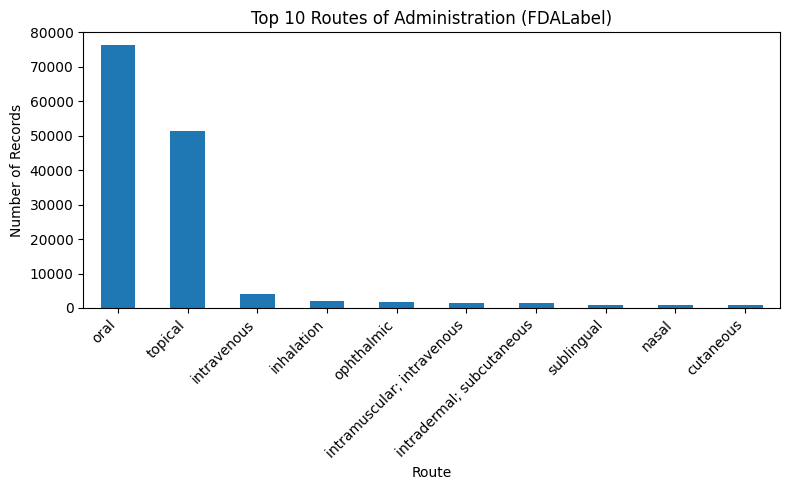

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Top 10 Routes
if "route" in df_fda_enriched.columns:
    top_routes = df_fda_enriched['route'].value_counts().head(10)
    plt.figure(figsize=(8, 5))
    top_routes.plot(kind='bar')
    plt.title("Top 10 Routes of Administration (FDALabel)")
    plt.xlabel("Route")
    plt.ylabel("Number of Records")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

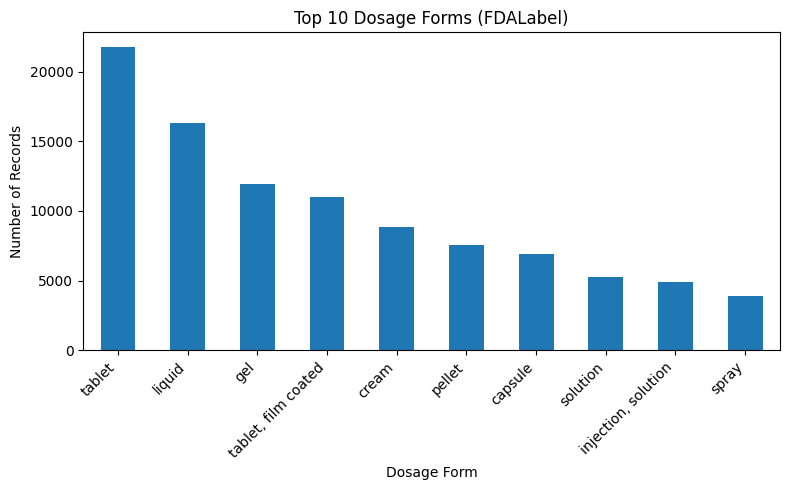

In [ ]:
# Top 10 Dosage Forms
if "dosage_form" in df_fda_enriched.columns:
    top_dosage = df_fda_enriched['dosage_form'].value_counts().head(10)
    plt.figure(figsize=(8, 5))
    top_dosage.plot(kind='bar')
    plt.title("Top 10 Dosage Forms (FDALabel)")
    plt.xlabel("Dosage Form")
    plt.ylabel("Number of Records")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

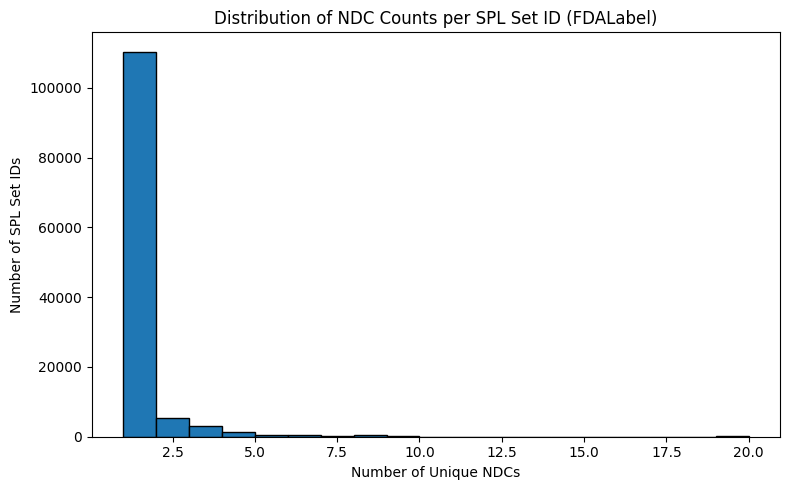

In [ ]:
#Histogram: NDCs per SPL Set ID (before explode)
if "spl_set_id" in df_fda.columns and "ndc" in df_fda.columns:
    ndc_counts_per_spl = df_fda.groupby("spl_set_id")["ndc"].nunique()
    plt.figure(figsize=(8, 5))
    plt.hist(ndc_counts_per_spl, bins=range(1, ndc_counts_per_spl.max() + 1), edgecolor='black')
    plt.title("Distribution of NDC Counts per SPL Set ID (FDALabel)")
    plt.xlabel("Number of Unique NDCs")
    plt.ylabel("Number of SPL Set IDs")
    plt.tight_layout()
    plt.show()

## **Decision Tree**
Authored by: Andrea Giraldo-Puerta

Co-Authors: Juliana McGaffic, David Arguello

In [ ]:
import os, re, time, requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Paths
epill_all_path = "/content/CPE-595-Final-Project/cleaned_epillid_all_data.csv"
epill_meta_path = "/content/CPE-595-Final-Project/cleaned_epillid_metadata_only.csv"
fda_path   = "/content/CPE-595-Final-Project/fdalabel_clean_enriched.csv"

#  FOR FUTURE work where to save a more-enriched FDA file (openFDA batch)
fda_plus_path    = "/content/CPE-595-Final-Project/fdalabel_clean_enriched_plus.csv"
RUN_ENRICH = False   # <— set True if you want to call openFDA to fill more text (slow)

# Load data
epill_all  = pd.read_csv(epill_all_path, low_memory=False)
epill_meta = pd.read_csv(epill_meta_path, low_memory=False)
fda        = pd.read_csv(fda_path, low_memory=False)

print("[INFO] ePillID(all) rows:", len(epill_all), "cols:", epill_all.columns.tolist())
print("[INFO] ePillID(meta) rows:", len(epill_meta), "cols:", epill_meta.columns.tolist())
print("[INFO] FDA rows:", len(fda), "cols:", fda.columns.tolist())

# We’ll use the metadata-only file (it already has label_encoded etc.)
df_epill = epill_meta.copy()


[INFO] ePillID(all) rows: 13532 cols: ['images', 'pilltype_id', 'label_code_id', 'prod_code_id', 'is_ref', 'is_front', 'is_new', 'image_path', 'label']
[INFO] ePillID(meta) rows: 13532 cols: ['images', 'pilltype_id', 'label_code_id', 'prod_code_id', 'is_ref', 'is_front', 'is_new', 'image_path', 'label', 'label_encoded']
[INFO] FDA rows: 148084 cols: ['spl_set_id', 'brand_name', 'generic_name', 'company', 'route', 'dosage_form', 'ndc', 'labeler_code_num', 'product_code_num', 'fdalabel_link', 'dailymed_link', 'indications', 'warnings', 'adverse', 'has_text']


In [ ]:
# Clean + coerce ePillID keys
for c in ["pilltype_id","label","image_path"]:
    if c in df_epill.columns:
        df_epill[c] = df_epill[c].astype(str).str.strip()

# Coerce numeric columns (may be floats on load -> convert cleanly)
for c in ["label_code_id","prod_code_id"]:
    if c in df_epill.columns:
        df_epill[c] = pd.to_numeric(df_epill[c], errors="coerce")

# Fallback parser from pilltype_id/label when numeric keys are missing
RE_LBL_PROD = re.compile(r"(\d{4,5})-(\d{3,4})")  # e.g., 00093-0148 or 85160-200

def extract_lbl_prod_from_text(s):
    if not isinstance(s, str):
        return None, None
    m = RE_LBL_PROD.search(s)
    if m:
        return m.group(1), m.group(2)
    return None, None

need_lbl = df_epill["label_code_id"].isna() if "label_code_id" in df_epill.columns else pd.Series(True, index=df_epill.index)
need_prd = df_epill["prod_code_id"].isna()  if "prod_code_id"  in df_epill.columns else pd.Series(True, index=df_epill.index)

if "pilltype_id" in df_epill.columns:
    vals = df_epill.loc[need_lbl | need_prd, "pilltype_id"].apply(extract_lbl_prod_from_text)
    df_epill.loc[need_lbl, "label_code_id"] = pd.to_numeric(vals.apply(lambda t: t[0]), errors="coerce")
    df_epill.loc[need_prd, "prod_code_id"]  = pd.to_numeric(vals.apply(lambda t: t[1]), errors="coerce")

# If still missing, try 'label'
need_lbl = df_epill["label_code_id"].isna()
need_prd = df_epill["prod_code_id"].isna()
if "label" in df_epill.columns and (need_lbl.any() or need_prd.any()):
    vals2 = df_epill.loc[need_lbl | need_prd, "label"].apply(extract_lbl_prod_from_text)
    df_epill.loc[need_lbl, "label_code_id"] = pd.to_numeric(vals2.apply(lambda t: t[0]), errors="coerce")
    df_epill.loc[need_prd, "prod_code_id"]  = pd.to_numeric(vals2.apply(lambda t: t[1]), errors="coerce")

ok_epill = df_epill["label_code_id"].notna() & df_epill["prod_code_id"].notna()
print(f"[INFO] ePillID rows with usable keys: {ok_epill.sum()} / {len(df_epill)}")
if ok_epill.any():
    print(df_epill.loc[ok_epill, ["label_code_id","prod_code_id"]].head())

[INFO] ePillID rows with usable keys: 13532 / 13532
   label_code_id  prod_code_id
0          51285            92
1             93           148
2             93          7248
3             93           928
4          50111           459


In [ ]:
#Ensure FDA keys exist & numeric
for c in ["labeler_code_num","product_code_num"]:
    if c in fda.columns:
        fda[c] = pd.to_numeric(fda[c], errors="coerce")
    else:
        raise ValueError(f"FDA is missing required column: {c}")

In [ ]:
#Collapse FDA duplicates per (labeler_code_num, product_code_num) keeping richest text
def _len_or_zero(x):
    return len(str(x)) if pd.notna(x) else 0

text_cols_for_score = [c for c in ["indications","warnings","adverse","brand_name","generic_name"] if c in fda.columns]
fda["_text_score"] = fda[text_cols_for_score].apply(lambda r: sum(_len_or_zero(v) for v in r), axis=1)
fda = (
    fda.sort_values("_text_score", ascending=False)
       .drop_duplicates(subset=["labeler_code_num","product_code_num"], keep="first")
       .drop(columns="_text_score")
       .reset_index(drop=True)
)
print("[INFO] FDA collapsed to richest text per (labeler, product):", len(fda))

[INFO] FDA collapsed to richest text per (labeler, product): 145400


In [ ]:
#Adding ndc_2part to FDA for visibility (join remains numeric)
if "ndc" in fda.columns:
    fda["ndc_2part"] = fda["ndc"].astype(str).str.replace(r"^(\d{4,5}-\d{3,4})-\d{1,2}$", r"\1", regex=True)

#Enrich more text from openFDA (batch)
if RUN_ENRICH:
    fda_enrich = fda.copy()
    if "spl_set_id" in fda_enrich.columns:
        set_ids = fda_enrich["spl_set_id"].dropna().unique().tolist()
        out_rows = []
        for sid in tqdm(set_ids[:5000]):  # adjust as needed
            try:
                r = requests.get(
                    "https://api.fda.gov/drug/label.json",
                    params={"search": f'openfda.spl_set_id:"{sid}"', "limit": 1},
                    timeout=15
                )
                if r.status_code != 200:
                    continue
                res = r.json().get("results", [])
                if not res:
                    continue
                rec = res[0]
                out_rows.append({
                    "spl_set_id": sid,
                    "indications": " ".join(rec.get("indications_and_usage", []))[:8000],
                    "warnings": " ".join(rec.get("warnings_and_cautions", []) or rec.get("warnings", []))[:8000],
                    "adverse": " ".join(rec.get("adverse_reactions", []))[:8000],
                })
            except Exception:
                pass
            if len(out_rows) % 200 == 0:
                time.sleep(0.5)

        df_more = pd.DataFrame(out_rows)
        if not df_more.empty:
            fda_enrich = fda_enrich.merge(df_more, on="spl_set_id", how="left", suffixes=("", "_api"))
            for col in ["indications","warnings","adverse"]:
                if col in fda_enrich.columns and f"{col}_api" in fda_enrich.columns:
                    fda_enrich[col] = fda_enrich[col].fillna(fda_enrich[f"{col}_api"])
                    fda_enrich.drop(columns=[f"{col}_api"], inplace=True)
            fda = fda_enrich
            fda.to_csv(fda_plus_path, index=False)
            print("[INFO] openFDA enrichment merged and saved →", fda_plus_path)
        else:
            print("[INFO] No new text from openFDA.")
    else:
        print("[WARN] spl_set_id not available; cannot batch enrich via openFDA.")

In [ ]:
# Diagnostics before join
pairs_epill = pd.MultiIndex.from_arrays([df_epill.loc[ok_epill,"label_code_id"], df_epill.loc[ok_epill,"prod_code_id"]])
pairs_epill = set(pairs_epill.dropna().unique())

pairs_fda = pd.MultiIndex.from_arrays([fda["labeler_code_num"], fda["product_code_num"]])
pairs_fda = set(pairs_fda.dropna().unique())

intersection = pairs_epill.intersection(pairs_fda)
print(f"[DIAG] Distinct ePillID pairs: {len(pairs_epill)} | FDA pairs: {len(pairs_fda)} | Intersect: {len(intersection)}")

if len(intersection) == 0:
    print("\n[DEBUG] Sample ePillID key pairs (first 10):")
    print(list(pairs_epill)[:10])
    print("\n[DEBUG] Sample FDA key pairs (first 10):")
    print(list(pairs_fda)[:10])

[DIAG] Distinct ePillID pairs: 4826 | FDA pairs: 145400 | Intersect: 2065


In [ ]:
# Join
feat_cols = ["brand_name","generic_name","route","dosage_form","ndc","indications","warnings","adverse"]
feat_cols = [c for c in feat_cols if c in fda.columns]
fda_sub = fda[["labeler_code_num","product_code_num"] + feat_cols].copy()

joined = df_epill.merge(
    fda_sub,
    left_on=["label_code_id","prod_code_id"],
    right_on=["labeler_code_num","product_code_num"],
    how="left"
)

coverage = float(joined["ndc"].notna().mean()) if "ndc" in joined.columns else 0.0
print(f"\n[INFO] Join coverage: {coverage:.2%} of ePillID rows matched FDA rows")
peek_cols = [c for c in ["images","image_path","label","pilltype_id","label_code_id","prod_code_id","ndc","brand_name","route","dosage_form"] if c in joined.columns]
print(joined[peek_cols].head(8))


[INFO] Join coverage: 39.53% of ePillID rows matched FDA rows
     images                      image_path                   label  \
0     0.jpg     fcn_mix_weight/dc_224/0.jpg  51285-0092-87_BE305F72   
1    10.jpg    fcn_mix_weight/dc_224/10.jpg  00093-0148-01_4629A34D   
2   100.jpg   fcn_mix_weight/dc_224/100.jpg  00093-7248-06_7829BC3D   
3  1003.jpg  fcn_mix_weight/dc_224/1003.jpg  00093-0928-06_6926B4E5   
4  1004.jpg  fcn_mix_weight/dc_224/1004.jpg  50111-0459-01_1C300E70   
5  1005.jpg  fcn_mix_weight/dc_224/1005.jpg  16252-0590-99_2B2015D0   
6  1006.jpg  fcn_mix_weight/dc_224/1006.jpg  00093-7220-06_692934D9   
7  1007.jpg  fcn_mix_weight/dc_224/1007.jpg  47335-0894-81_7F1DBFBD   

              pilltype_id  label_code_id  prod_code_id        ndc  \
0  51285-0092-87_BE305F72          51285            92        NaN   
1  00093-0148-01_4629A34D             93           148        NaN   
2  00093-7248-06_7829BC3D             93          7248        NaN   
3  00093-0928-06_6926

In [ ]:
%pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.0 MB/s eta 0:00:00


In [ ]:
#Fuzzy name join for unmatched rows
try:
    from rapidfuzz import process, fuzz
    can_fuzzy = True
except Exception:
    can_fuzzy = False
    print("[INFO] rapidfuzz not installed; skipping fuzzy join.")

if can_fuzzy:
    fda_names = (
        fda.assign(_name=(fda.get("brand_name","").astype(str) + " " + fda.get("generic_name","").astype(str)).str.lower().str.strip())
           .dropna(subset=["_name"])
    )
    name_to_pair = dict(zip(fda_names["_name"], zip(fda_names["labeler_code_num"], fda_names["product_code_num"])))

    umask = joined["ndc"].isna()
    if umask.any() and len(name_to_pair) > 0:
        cand_series = (joined.loc[umask, "pilltype_id"].astype(str) + " " + joined.loc[umask, "label"].astype(str)).str.lower()
        choices = list(name_to_pair.keys())

        matched_pairs = []
        for s in cand_series.head(2000):  # cap for speed
            match = process.extractOne(s, choices, scorer=fuzz.WRatio)
            if match and match[1] >= 90:  # high confidence
                matched_pairs.append(name_to_pair[match[0]])
            else:
                matched_pairs.append((np.nan, np.nan))

        joined.loc[umask, "labeler_code_num_fuzzy"] = [p[0] for p in matched_pairs] + [np.nan]*(umask.sum()-len(matched_pairs))
        joined.loc[umask, "product_code_num_fuzzy"] = [p[1] for p in matched_pairs] + [np.nan]*(umask.sum()-len(matched_pairs))

        has_fuzzy = joined["labeler_code_num_fuzzy"].notna() & joined["product_code_num_fuzzy"].notna()
        if has_fuzzy.any():
            fda_sub2 = fda[["labeler_code_num","product_code_num","ndc","brand_name","generic_name","route","dosage_form","indications","warnings","adverse"]]
            joined = joined.merge(
                fda_sub2,
                left_on=["labeler_code_num_fuzzy","product_code_num_fuzzy"],
                right_on=["labeler_code_num","product_code_num"],
                how="left",
                suffixes=("", "_fuzzy")
            )
            for col in ["ndc","brand_name","generic_name","route","dosage_form","indications","warnings","adverse"]:
                joined[col] = joined[col].fillna(joined.get(f"{col}_fuzzy"))
        print("[INFO] Applied fuzzy name join to improve coverage.")

[INFO] Applied fuzzy name join to improve coverage.


In [ ]:
#Bucket + feature engineering
def norm(s): return str(s).lower().strip()

for c in ["indications","warnings","adverse","brand_name","generic_name"]:
    if c in joined.columns:
        joined[c] = joined[c].fillna("").astype(str)
text_cols_present = [c for c in ["indications","warnings","adverse","brand_name","generic_name"] if c in joined.columns]
joined["text_src"] = joined[text_cols_present].agg(" ".join, axis=1).str.lower().str.replace(r"\s+", " ", regex=True) if text_cols_present else ""

# Bucket lexicon
buckets = {
    "pain":        ["pain","analgesic","analgesia","migraine","headache","ibuprofen","acetaminophen","paracetamol","nsaid","naproxen","opioid","tramadol"],
    "allergy":     ["allergy","antihistamine","hay fever","allergic rhinitis","cetirizine","loratadine","fexofenadine","diphenhydramine","chlorpheniramine"],
    "infection":   ["antibiotic","bacterial","infection","antifungal","antiviral","penicillin","amoxicillin","azithromycin","doxycycline","metronidazole","cephalexin","fluconazole","acyclovir"],
    "gi":          ["nausea","heartburn","reflux","gerd","ibs","constipation","diarrhea","antacid","omeprazole","lansoprazole","pantoprazole","metoclopramide","ondansetron"],
    "cv":          ["hypertension","blood pressure","cholesterol","lipid","angina","statin","heart failure","ace inhibitor","beta blocker","amlodipine","lisinopril","metoprolol","atorvastatin"],
    "cns":         ["depression","anxiety","insomnia","adhd","seizure","antipsychotic","ssri","benzodiazepine","sertraline","fluoxetine","escitalopram","quetiapine","risperidone","alprazolam"],
    "endocrine":   ["diabetes","insulin","metformin","thyroid","levothyroxine","glipizide","empagliflozin","semaglutide"],
    "derm":        ["dermatitis","psoriasis","eczema","acne","topical","skin","hydrocortisone","clobetasol","tretinoin","mupirocin"],
    "resp":        ["asthma","copd","bronch","inhalation","albuterol","fluticasone","salmeterol","montelukast","budesonide","formoterol"]
}
def label_bucket_from_text(txt):
    t = norm(txt)
    for b, kws in buckets.items():
        for k in kws:
            if k in t:
                return b
    return None

joined["condition_bucket"] = joined["text_src"].apply(label_bucket_from_text)

def bucket_from_route(route_txt):
    t = norm(route_txt)
    if any(k in t for k in ["inhalation","inhaled","nebul","respir"]): return "resp"
    if any(k in t for k in ["nasal"]): return "allergy"
    if any(k in t for k in ["topical","cutaneous","dermal","transdermal","skin"]): return "derm"
    return None

def bucket_from_dosage(form_txt):
    t = norm(form_txt)
    if any(k in t for k in ["cream","ointment","lotion","gel","shampoo","foam","solution topical"]): return "derm"
    if any(k in t for k in ["inhalation","aerosol","nebulizer","inhaler"]): return "resp"
    if any(k in t for k in ["nasal","spray (nasal)"]): return "allergy"
    return None

if "route" in joined.columns:
    joined.loc[joined["condition_bucket"].isna(), "condition_bucket"] = \
        joined.loc[joined["condition_bucket"].isna(), "route"].apply(bucket_from_route)

if "dosage_form" in joined.columns:
    joined.loc[joined["condition_bucket"].isna(), "condition_bucket"] = \
        joined.loc[joined["condition_bucket"].isna(), "dosage_form"].apply(bucket_from_dosage)

joined["condition_bucket"] = joined["condition_bucket"].fillna("other")
print("[INFO] Bucket distribution AFTER text+fallbacks (top 10):")
print(joined["condition_bucket"].value_counts().head(10))

# one-hot + keyword features
meta_parts = []
for col in ["route","dosage_form"]:
    if col in joined.columns:
        meta_parts.append(pd.get_dummies(joined[col].fillna("unknown"), prefix=col, drop_first=True))
X_meta = pd.concat(meta_parts, axis=1) if meta_parts else pd.DataFrame(index=joined.index)

X_kw = pd.DataFrame(index=joined.index)
for kw in ["pain","allergy","infection","nausea","hypertension","diabetes","dermatitis","asthma","bronch","insulin","statin","omeprazole"]:
    X_kw[f"kw_{kw}"] = joined["text_src"].astype(str).str.contains(kw, case=False, na=False).astype(int)

X = pd.concat([X_meta, X_kw], axis=1).fillna(0).astype(np.float32)
y = joined["condition_bucket"].astype(str)

vc = y.value_counts()
print("[INFO] Bucket counts before pruning:\n", vc)
rare = vc[vc < 30].index
if len(rare) > 0:
    mask = ~y.isin(rare)
    X, y = X[mask], y[mask]
    print(f"[INFO] Dropped {len(rare)} rare buckets (<30). Remaining rows: {len(y)}; classes: {y.nunique()}")

if y.nunique() < 2:
    top2 = y.value_counts().head(2).index
    mask = y.isin(top2)
    X, y = X[mask], y[mask]
    print(f"[WARN] Forcing to top-2 buckets: {list(top2)}. Rows: {len(y)}")

if X.shape[1] == 0:
    raise ValueError("No DT features built.")

print("[INFO] Final DT matrix:", X.shape, "classes:", y.nunique())

[INFO] Bucket distribution AFTER text+fallbacks (top 10):
condition_bucket
other        11999
cv             422
infection      285
endocrine      227
gi             183
pain           175
cns            127
derm            50
allergy         40
resp            24
Name: count, dtype: int64
[INFO] Bucket counts before pruning:
 condition_bucket
other        11999
cv             422
infection      285
endocrine      227
gi             183
pain           175
cns            127
derm            50
allergy         40
resp            24
Name: count, dtype: int64
[INFO] Dropped 1 rare buckets (<30). Remaining rows: 13508; classes: 9
[INFO] Final DT matrix: (13508, 76) classes: 9


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Config
RANDOM_STATE = 42
TEST_SIZE = 0.20
MIN_CLASS_COUNT_DT = 30
MIN_CLASS_COUNT_TXT = 20
MAX_FEATS_TFIDF = 5000
NGRAMS_TFIDF = (1, 2)
MIN_DF_TFIDF = 5

# Helpers
def print_eval(title, y_true, y_pred, labels=None):
    print(f"\n=== {title} ===")
    print(classification_report(y_true, y_pred, zero_division=0))
    if labels is None:
        labels = np.unique(np.concatenate([np.unique(y_true), np.unique(y_pred)]))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    print("Confusion matrix (counts):")
    print(cm_df)
    cm_norm = (cm_df.T / cm_df.sum(axis=1)).T.fillna(0)
    print("\nConfusion matrix (row-normalized):")
    print(cm_norm.round(3))
    return cm_df, cm_norm

def prune_by_min_count(y_series, min_count, X_frame=None):
    vc = y_series.value_counts()
    keep = y_series.isin(vc[vc >= min_count].index)
    if X_frame is None:
        return keep
    return keep, X_frame[keep], y_series[keep]

#Build a single, consistent text mask once
text_cols = [c for c in ["indications","warnings","adverse","brand_name","generic_name"] if c in joined.columns]
joined["has_any_text"] = False
if text_cols:
    joined["has_any_text"] = joined[text_cols].apply(lambda r: any(bool(str(x).strip()) for x in r), axis=1)

In [ ]:
# Decision Tree (tabular DT)
# Uses X (tabular) and y from your prepared features above (already pruned once)
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
dt.fit(X_tr, y_tr)
y_va_pred = dt.predict(X_va)
cm_dt_df, cm_dt_norm = print_eval("Decision Tree (baseline on all rows)", y_va, y_va_pred, labels=dt.classes_)



=== Decision Tree (baseline on all rows) ===
              precision    recall  f1-score   support

     allergy       0.00      0.00      0.00         8
         cns       0.04      0.36      0.07        25
          cv       0.98      0.47      0.63        85
        derm       0.50      0.30      0.38        10
   endocrine       0.10      0.89      0.18        45
          gi       0.52      0.65      0.58        37
   infection       0.10      0.54      0.17        57
       other       1.00      0.69      0.82      2400
        pain       0.55      0.17      0.26        35

    accuracy                           0.67      2702
   macro avg       0.42      0.45      0.34      2702
weighted avg       0.94      0.67      0.77      2702

Confusion matrix (counts):
           allergy  cns  cv  derm  endocrine  gi  infection  other  pain
allergy          0    3   0     0          0   0          5      0     0
cns              0    9   0     0          4   0         12      0     0
cv 

In [ ]:
# Top-k (≥80%) for a few examples
def top_k_until_80pct(model, X_row, label_names, cum_thresh=0.80, k_cap=10):
    proba = model.predict_proba(X_row)[0]
    order = np.argsort(proba)[::-1]
    probs = proba[order]
    labs  = label_names[order]
    keep, cum = [], 0.0
    for lab, p in zip(labs, probs):
        keep.append((lab, float(p)))
        cum += p
        if cum >= cum_thresh or len(keep) >= k_cap:
            break
    return keep

label_names = np.array(dt.classes_)
n_demo = min(5, len(X_va))
print("\nTop-k (≥80% cum prob) examples:")
for idx in np.random.choice(len(X_va), size=n_demo, replace=False):
    row = X_va.iloc[idx:idx+1]
    print(top_k_until_80pct(dt, row, label_names))


Top-k (≥80% cum prob) examples:
[('other', 1.0)]
[('infection', 0.22196592689937403), ('cns', 0.20916512373332052), ('derm', 0.17365569575068684), ('allergy', 0.13954475551394485), ('gi', 0.07816205483886107)]
[('endocrine', 0.3171443363953659), ('pain', 0.15354160286175708), ('allergy', 0.14927655833781917), ('cv', 0.10040361985135195), ('infection', 0.09951770555854604)]
[('gi', 0.8060230292294067)]
[('infection', 0.22196592689937403), ('cns', 0.20916512373332052), ('derm', 0.17365569575068684), ('allergy', 0.13954475551394485), ('gi', 0.07816205483886107)]


In [ ]:
#TF-IDF + Logistic Regression (text)

# Build text view ONCE
text_series = joined["text_src"].fillna("").astype(str)
y_all       = joined["condition_bucket"].astype(str)
mask_txt    = joined["has_any_text"]

# Restrict to text rows
text_series = text_series[mask_txt]
y_text_all  = y_all[mask_txt]

# Prune ultra-rare classes within the text subset
keep_mask = prune_by_min_count(y_text_all, MIN_CLASS_COUNT_TXT)
text_series_keep = text_series[keep_mask]
y_text_keep      = y_text_all[keep_mask]

if y_text_keep.nunique() >= 2 and len(y_text_keep) >= 200:
    tfidf = TfidfVectorizer(min_df=MIN_DF_TFIDF, ngram_range=NGRAMS_TFIDF, max_features=MAX_FEATS_TFIDF)
    X_tfidf = tfidf.fit_transform(text_series_keep)

    # Set seed here for deterministic sampling
    np.random.seed(RANDOM_STATE)

    X_tr_txt, X_va_txt, y_tr_txt, y_va_txt = train_test_split(
        X_tfidf, y_text_keep, test_size=TEST_SIZE, stratify=y_text_keep, random_state=RANDOM_STATE
    )

    clf = LogisticRegression(max_iter=2000, C=2.0, class_weight=None, n_jobs=-1)
    clf.fit(X_tr_txt, y_tr_txt)
    y_va_pred_txt = clf.predict(X_va_txt)
    _cm_txt_df, _cm_txt_norm = print_eval("TF-IDF + LogReg (text subset)", y_va_txt, y_va_pred_txt, labels=clf.classes_)
else:
    print(f"[WARN] Not enough text rows/classes after filtering. Rows={len(y_text_keep)}, classes={y_text_keep.nunique()}")


=== TF-IDF + LogReg (text subset) ===
              precision    recall  f1-score   support

     allergy       1.00      0.62      0.77         8
         cns       1.00      1.00      1.00        25
          cv       1.00      0.99      0.99        85
        derm       1.00      0.60      0.75        10
   endocrine       1.00      1.00      1.00        45
          gi       1.00      0.97      0.99        37
   infection       1.00      1.00      1.00        57
       other       0.99      1.00      0.99       763
        pain       0.97      1.00      0.99        35
        resp       1.00      0.40      0.57         5

    accuracy                           0.99      1070
   macro avg       1.00      0.86      0.90      1070
weighted avg       0.99      0.99      0.99      1070

Confusion matrix (counts):
           allergy  cns  cv  derm  endocrine  gi  infection  other  pain  resp
allergy          5    0   0     0          0   0          0      3     0     0
cns              

In [ ]:
# Compact, data-driven plots
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

os.makedirs("figures", exist_ok=True)

# Small helpers
def _report_arrays(y_true, y_pred, labels):
    """Return per-class precision/recall/f1/support aligned to labels + acc, macro_f1."""
    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    prec = [rep.get(str(lbl), {}).get("precision", 0.0) for lbl in labels]
    rec  = [rep.get(str(lbl), {}).get("recall", 0.0)    for lbl in labels]
    f1   = [rep.get(str(lbl), {}).get("f1-score", 0.0)  for lbl in labels]
    sup  = [rep.get(str(lbl), {}).get("support", 0)     for lbl in labels]
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = rep.get("macro avg", {}).get("f1-score", np.nan)
    return np.array(prec), np.array(rec), np.array(f1), np.array(sup), acc, macro_f1

def _cm_counts(y_true, y_pred, labels):
    return confusion_matrix(y_true, y_pred, labels=labels).astype(float)

def _plot_cm(cm, labels, title, fname):
    fig, ax = plt.subplots(figsize=(max(6, 0.5*len(labels)), max(5, 0.5*len(labels))))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    vmax = cm.max() if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i, j]
            ax.text(j, i, f"{v:.0f}" if v.is_integer() else f"{v:.2f}",
                    ha="center", va="center",
                    color=("white" if vmax and v > vmax/2 else "black"), fontsize=8)
    plt.tight_layout()
    plt.savefig(f"figures/{fname}", dpi=200); plt.show()

def _plot_cm_row_norm(cm_counts, labels, title, fname):
    rs = cm_counts.sum(axis=1, keepdims=True); rs[rs == 0] = 1.0
    _plot_cm(cm_counts / rs, labels, title, fname)

def _bar_triplet(prec, rec, f1, labels, title, fname):
    idx = np.arange(len(labels)); w = 0.27
    fig, ax = plt.subplots(figsize=(max(8, 0.6*len(labels)), 5))
    ax.bar(idx - w, prec, width=w, label="Precision")
    ax.bar(idx,       rec,  width=w, label="Recall")
    ax.bar(idx + w,   f1,   width=w, label="F1")
    ax.set_xticks(idx); ax.set_xticklabels(labels, rotation=90)
    ax.set_ylim(0, 1.05); ax.set_title(title); ax.legend()
    plt.tight_layout(); plt.savefig(f"figures/{fname}", dpi=200); plt.show()

def _model_summary(badges, title, fname):
    """badges: list of (label, acc, macro_f1)"""
    if not badges: return
    names = [b[0] for b in badges]
    accs  = [b[1] for b in badges]
    mfs   = [b[2] for b in badges]
    idx = np.arange(len(names)); w = 0.35
    fig, ax = plt.subplots(figsize=(max(8, 1.8*len(names)), 5))
    ax.bar(idx - w/2, accs, width=w, label="Accuracy")
    ax.bar(idx + w/2, mfs,  width=w, label="Macro F1")
    ax.set_xticks(idx); ax.set_xticklabels(names, rotation=0)
    ax.set_ylim(0, 1.05); ax.set_title(title); ax.legend()
    plt.tight_layout(); plt.savefig(f"figures/{fname}", dpi=200); plt.show()

def _topk_plot_dt(dt_model, X_val, title, fname, cum_thresh=0.80, k_cap=10, n_samples=200):
    from collections import Counter
    if not hasattr(dt_model, "predict_proba"): return
    labels = list(dt_model.classes_)
    counts = Counter(); total = 0
    # sample rows
    pick = min(n_samples, len(X_val))
    for idx in np.random.choice(len(X_val), size=pick, replace=False):
        row = X_val.iloc[idx:idx+1]
        proba = dt_model.predict_proba(row)[0]
        order = np.argsort(proba)[::-1]
        cum = 0.0
        for i in order[:k_cap]:
            counts[labels[i]] += 1
            cum += proba[i]
            if cum >= cum_thresh: break
        total += 1
    if total == 0: return
    labs, vals = zip(*counts.items())
    perc = [v/total*100 for v in vals]
    fig, ax = plt.subplots(figsize=(max(8, 0.5*len(labs)), 5))
    ax.bar(labs, perc)
    ax.set_ylabel("Appearance in Top-k (%)"); ax.set_xlabel("Class"); ax.set_title(title)
    plt.xticks(rotation=45); plt.tight_layout(); plt.savefig(f"figures/{fname}", dpi=200); plt.show()

# Collect available models/predictions from earlier code and plot
summary_rows = []

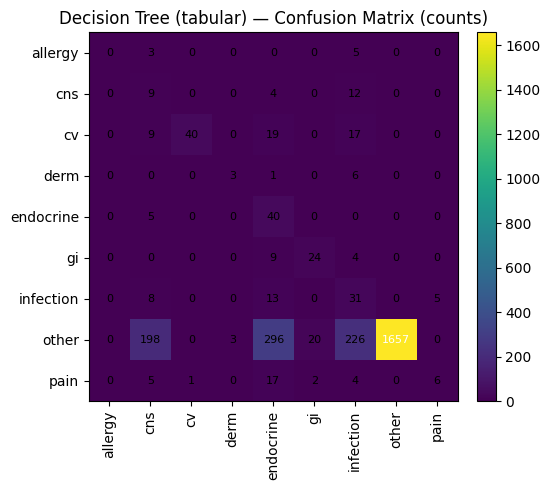

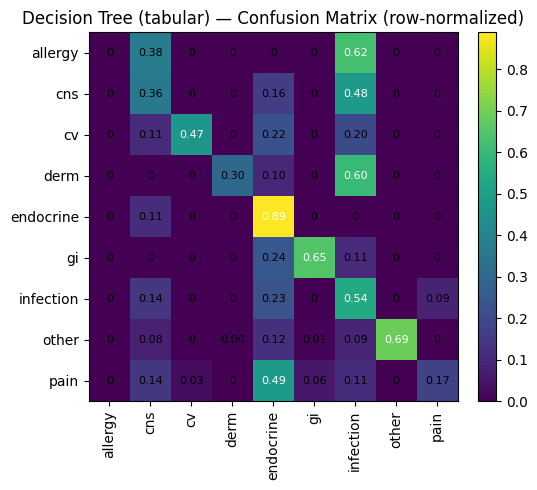

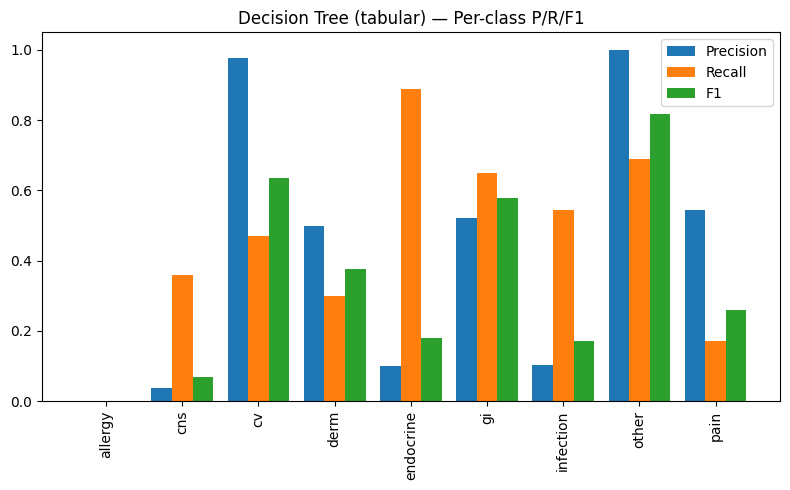

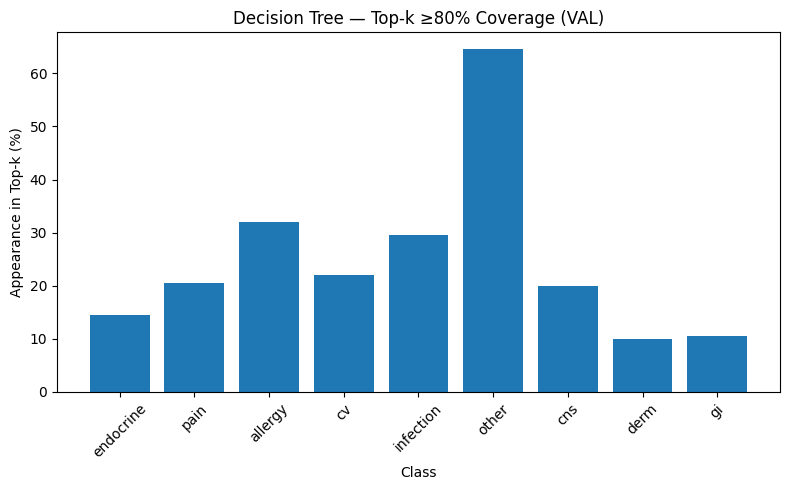

In [ ]:
# Decision Tree baseline on tabular (expects: dt, X_va, y_va)
try:
    y_va_pred_dt = dt.predict(X_va)
    labels_dt = list(dt.classes_)
    prec, rec, f1, sup, acc, macro_f1 = _report_arrays(y_va, y_va_pred_dt, labels_dt)
    cm_dt = _cm_counts(y_va, y_va_pred_dt, labels_dt)
    _plot_cm(cm_dt, labels_dt, "Decision Tree (tabular) — Confusion Matrix (counts)", "dt_cm_counts.png")
    _plot_cm_row_norm(cm_dt, labels_dt, "Decision Tree (tabular) — Confusion Matrix (row-normalized)", "dt_cm_rownorm.png")
    _bar_triplet(prec, rec, f1, labels_dt, "Decision Tree (tabular) — Per-class P/R/F1", "dt_per_class.png")
    _topk_plot_dt(dt, X_va, "Decision Tree — Top-k ≥80% Coverage (VAL)", "dt_topk_coverage.png")
    summary_rows.append(("DT (tabular)", acc, macro_f1))
except Exception:
    pass

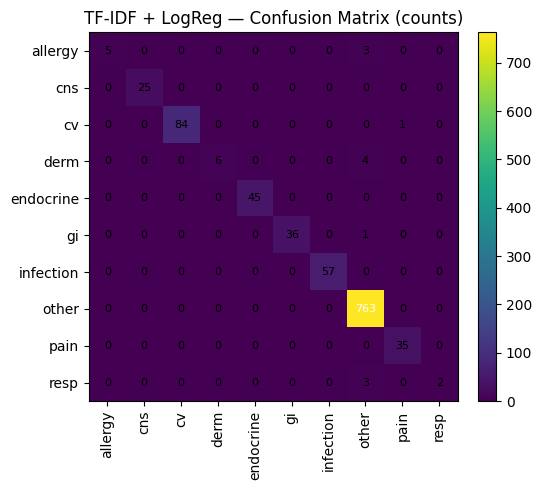

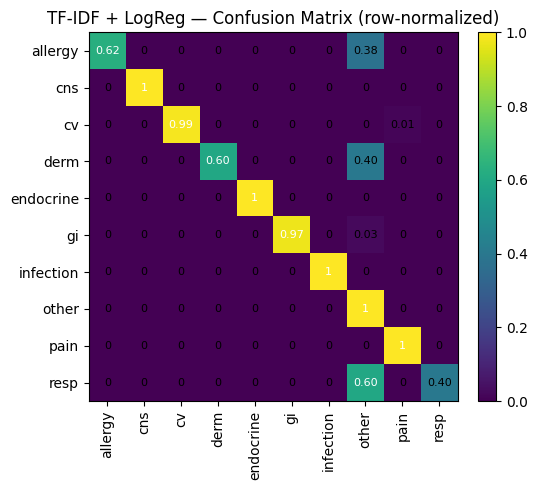

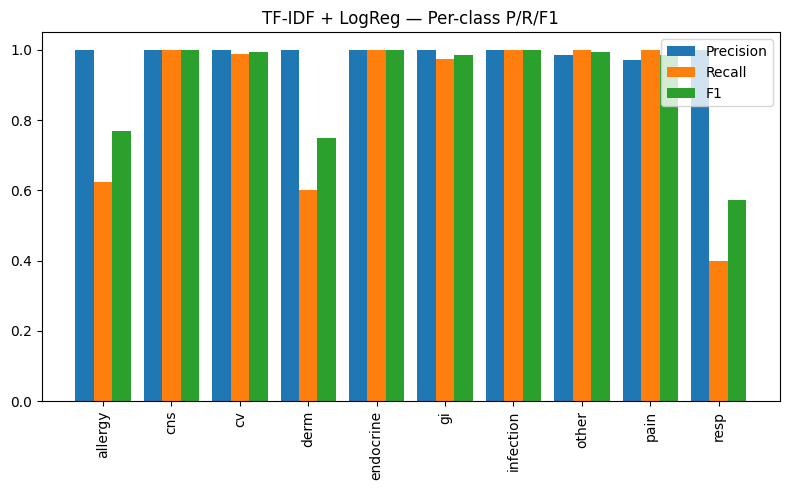

In [ ]:
# TF-IDF + Logistic Regression (expects: clf, X_va_txt, y_va_txt)
try:
    y_va_pred_txt = clf.predict(X_va_txt)
    labels_txt = list(clf.classes_)
    prec, rec, f1, sup, acc, macro_f1 = _report_arrays(y_va_txt, y_va_pred_txt, labels_txt)
    cm_txt = _cm_counts(y_va_txt, y_va_pred_txt, labels_txt)
    _plot_cm(cm_txt, labels_txt, "TF-IDF + LogReg — Confusion Matrix (counts)", "tfidf_cm_counts.png")
    _plot_cm_row_norm(cm_txt, labels_txt, "TF-IDF + LogReg — Confusion Matrix (row-normalized)", "tfidf_cm_rownorm.png")
    _bar_triplet(prec, rec, f1, labels_txt, "TF-IDF + LogReg — Per-class P/R/F1", "tfidf_per_class.png")
    summary_rows.append(("TF-IDF+LogReg (text subset)", acc, macro_f1))
except Exception:
    pass

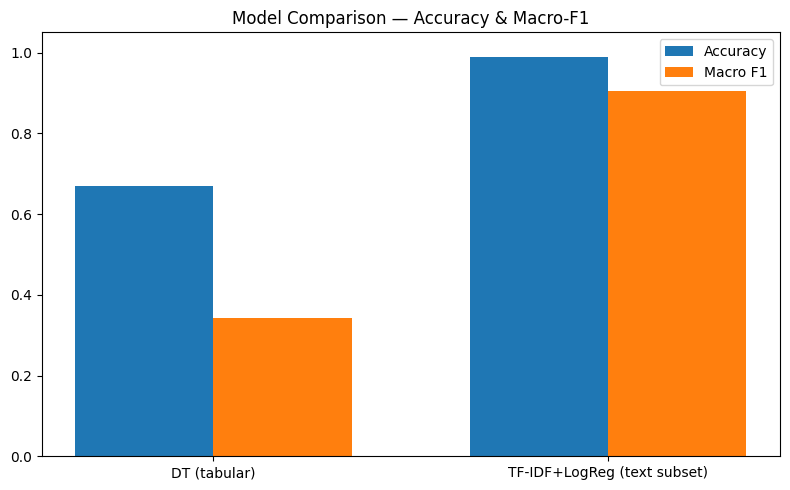

In [ ]:
# Overall comparison (Accuracy & Macro-F1)
_model_summary(summary_rows, "Model Comparison — Accuracy & Macro-F1", "overall_comparison.png")

In [ ]:
# ---------------------
# Save artifacts
# ---------------------
# out_join = "/content/CPE-595-Final-Project/epillid_fdalabel_joined.csv"
# joined.to_csv(out_join, index=False)
print(f"\n[INFO] Saved joined table")

#import pickle
# if clf is not None:
#     with open("/content/CPE-595-Final-Project/tfidf_vectorizer.pkl", "wb") as f:
#         pickle.dump(tfidf, f)
#     with open("/content/CPE-595-Final-Project/logreg_text.pkl", "wb") as f:
#         pickle.dump(clf, f)
# with open("/content/CPE-595-Final-Project/dt_tabular.pkl", "wb") as f:
#     pickle.dump(dt, f)
# X.columns.to_series().to_csv("/content/CPE-595-Final-Project/dt_feature_columns.csv", index=False)
print("Saved: tfidf_vectorizer.pkl, logreg_text.pkl, dt_tabular.pkl, dt_feature_columns.csv")


[INFO] Saved joined table
Saved: tfidf_vectorizer.pkl, logreg_text.pkl, dt_tabular.pkl, dt_feature_columns.csv


# **Comparison: CNN vs. SVM vs. Decision Tree** #

Authored by: Andrea Giraldo-Puerta

Co-Authors: Juliana McGaffic, David Arguello

In [ ]:
# === Final Comparison: Accuracy & F1 across CNN, SVM, DT ===
# Uses variables already created in your notebook:
# - CNN:    metrics_df (per-epoch Train_*/Val_* for ResNet18, DenseNet121, EfficientNet-B0)
# - SVM:    either `summary` with ['PCA Components','Accuracy','F1 Score'] OR
#           `summary` with ['pca','k','acc','f1'] from later grid, OR lists `accuracies`/`f1_scores`
# - DT:     dt, X_va, y_va (tabular), we recompute preds here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# ---------- Helpers ----------
def best_cnn_metrics_from_metrics_df(md: pd.DataFrame):
    """Pick the best CNN backbone at the final epoch by Val_Accuracy. Return (label, acc, f1)."""
    last_epoch = md['Epoch'].max()
    final = md[md['Epoch'] == last_epoch].copy()
    if final.empty:
        raise ValueError("metrics_df has no rows for the last epoch.")
    # Pick the backbone with the highest Val_Accuracy
    best_row = final.loc[final['Val_Accuracy'].idxmax()]
    label = f"CNN ({best_row['Model']})"
    # NOTE: Val_F1 in your notebook is Weighted-F1
    acc = float(best_row['Val_Accuracy'])
    f1  = float(best_row['Val_F1'])
    return label, acc, f1

In [ ]:
def best_svm_metrics():
    """
    Try multiple known places your code stores SVM results.
    Returns (label, acc, f1).
    """
    # 1) PCA sweep summary with pretty column names
    if 'summary' in globals():
        try:
            if {'PCA Components','Accuracy','F1 Score'}.issubset(set(summary.columns)):
                row = summary.sort_values('F1 Score', ascending=False).iloc[0]
                return ("SVM (best PCA)", float(row['Accuracy']), float(row['F1 Score']))
        except Exception:
            pass
        # 2) Later grid search summary with lowercase columns (k-NN/others may reuse the name)
        try:
            if {'pca','k','acc','f1'}.issubset(set(summary.columns)):
                row = summary.sort_values('f1', ascending=False).iloc[0]
                return (f"SVM (best PCA={int(row['pca'])})", float(row['acc']), float(row['f1']))
        except Exception:
            pass
    # 3) Fallback to lists from the PCA loop
    if 'accuracies' in globals() and 'f1_scores' in globals():
        try:
            a = list(accuracies)
            f = list(f1_scores)
            if len(a) and len(f):
                return ("SVM (best)", float(max(a)), float(max(f)))
        except Exception:
            pass
    raise ValueError("Could not locate SVM metrics. Ensure the PCA-tuning section ran (creates `summary`).")

In [ ]:
def dt_metrics():
    """Recompute DT accuracy & macro-F1 from dt, X_va, y_va."""
    if not all(name in globals() for name in ['dt','X_va','y_va']):
        raise ValueError("DT objects dt, X_va, y_va are not defined.")
    y_dt_pred = dt.predict(X_va)
    acc = accuracy_score(y_va, y_dt_pred)
    f1  = f1_score(y_va, y_dt_pred, average='macro', zero_division=0)
    return ("Decision Tree", float(acc), float(f1))

def tfidf_logreg_metrics():
    """Recompute TF-IDF+LogReg accuracy & macro-F1 from clf, X_va_txt, y_va_txt."""
    if not all(name in globals() for name in ['clf','X_va_txt','y_va_txt']):
        raise ValueError("TF-IDF+LogReg objects clf, X_va_txt, y_va_txt are not defined.")
    y_txt_pred = clf.predict(X_va_txt)
    acc = accuracy_score(y_va_txt, y_txt_pred)
    f1  = f1_score(y_va_txt, y_txt_pred, average='macro', zero_division=0)
    return ("TF-IDF+LogReg", float(acc), float(f1))

In [ ]:
# ---------- Collect metrics ----------
rows = []

# CNN (pick best backbone at last epoch)
if 'metrics_df' in globals():
    cnn_label, cnn_acc, cnn_f1 = best_cnn_metrics_from_metrics_df(metrics_df)
    rows.append((cnn_label, cnn_acc, cnn_f1))
else:
    print("[WARN] `metrics_df` not found; skipping CNN.")

# SVM (best config)
try:
    svm_label, svm_acc, svm_f1 = best_svm_metrics()
    rows.append((svm_label, svm_acc, svm_f1))
except Exception as e:
    print(f"[WARN] SVM metrics not found: {e}")

# Decision Tree (tabular)
try:
    dt_label, dt_acc, dt_f1 = dt_metrics()
    rows.append((dt_label, dt_acc, dt_f1))
except Exception as e:
    print(f"[WARN] DT metrics not found: {e}")

# TF-IDF + Logistic Regression (text subset)
try:
    txt_label, txt_acc, txt_f1 = tfidf_logreg_metrics()
    rows.append((txt_label, txt_acc, txt_f1))
except Exception as e:
    print(f"[WARN] TF-IDF+LogReg metrics not found: {e}")

# Build table
df_cmp = pd.DataFrame(rows, columns=["Model","Accuracy","F1"])
display(df_cmp.round(4))

,Model,Accuracy,F1
0,CNN (EfficientNet-B0),0.6494,0.6042
1,SVM (best PCA=50),0.2980,0.2736
2,Decision Tree,0.6699,0.3429
3,TF-IDF+LogReg,0.9888,0.9050


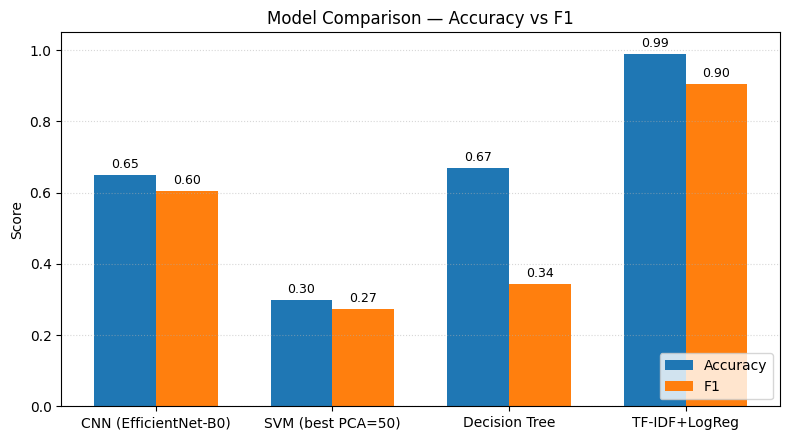

In [ ]:
# ---------- Plot ----------
labels = df_cmp["Model"].tolist()
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4.5))
b1 = ax.bar(x - width/2, df_cmp["Accuracy"].values, width, label="Accuracy")
b2 = ax.bar(x + width/2, df_cmp["F1"].values,       width, label="F1")

ax.set_xticks(x, labels, rotation=0)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Model Comparison — Accuracy vs F1")
ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", alpha=0.5)

# Annotate bars
for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f"{h:.2f}", xy=(bar.get_x()+bar.get_width()/2, h),
                    xytext=(0,3), textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()